<a href="https://colab.research.google.com/github/savadikarc/vae/blob/master/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/My Drive/DL_ML/VAE/Images_VAE/'
!ls /content/drive/My\ Drive/DL_ML/VAE

 Blog_Images			     'Copy of vae_fun.ipynb'
 conditional_vae_diag.ipynb	      Images_VAE
 conditional_vae_fun.ipynb	      vae_blogpost_diag.ipynb
'Copy of conditional_vae_fun.ipynb'   vae_fun.ipynb


In [ ]:
# PyTorch - 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms
import torch.nn.functional as F

# NumPy, standard
import numpy as np
from scipy.stats import norm

# Visualization
import imageio
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from keras.datasets import mnist

Using TensorFlow backend.


In [ ]:
latent_size = 2
hidden_size = 1024
base_filters = 8
batch_size = 2048
EPOCHS = 1000
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [ ]:
class EncoderFC(nn.Module):
    
    def __init__(self, latent_size=10):
        
        super(EncoderFC, self).__init__()
        self.latent_size = latent_size
        
        self.fc = nn.Sequential(
            nn.Linear(784, hidden_size, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, hidden_size, bias=True),
            nn.ReLU(inplace=True)
        )
        
        self.linear_mu = nn.Linear(hidden_size, latent_size)
        self.linear_log_var = nn.Linear(hidden_size, latent_size)
        
    def forward(self, x):
        
        x = x.view(-1, 784)
        
        features = self.fc(x)
        mu = self.linear_mu(features)
        log_var = self.linear_log_var(features)
        
        return mu, log_var

In [ ]:
class DecoderFC(nn.Module):
    
    def __init__(self, latent_size=10):
        
        super(DecoderFC, self).__init__()
        
        self.latent_size = latent_size
        
        self.fc = nn.Sequential(
            nn.Linear(latent_size, hidden_size, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, hidden_size, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, 784)
            
        )
        
        
        self.sigmoid =  nn.Sigmoid()
        
    def forward(self, z):
        
        x = self.fc(z)
        
        x = self.sigmoid(x)
        
        return x.view(-1, 1, 28, 28)
        

In [ ]:
def weight_init(m):
    
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        m.weight.data = nn.init.kaiming_normal_(m.weight.data)
        m.weight.data.requires_grad = True
        
        try:
            m.bias.data = torch.zeros(m.bias.data.size(), requires_grad=True)
        except AttributeError:
            pass
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data = torch.ones(m.weight.data.size(), requires_grad=True)
        m.bias.data = torch.zeros(m.bias.data.size(), requires_grad=True)

In [ ]:
encoder = EncoderFC(latent_size)
encoder.apply(weight_init)
encoder = encoder.to(device)

decoder = DecoderFC(latent_size)
decoder.apply(weight_init)
decoder = decoder.to(device)

In [ ]:
def train_step(batch_X, batch_y, criterion, optimizer_e, optimizer_d):
    
    optimizer_e.zero_grad()
    optimizer_d.zero_grad()
    
    x = torch.FloatTensor(batch_X).to(device)
    labels = torch.LongTensor(batch_y)
    
    # Predictive mean and log variance
    # Data in the range of -1 to 1
    # mu, log_var = encoder((x - 0.5) / 0.5)
    mu, log_var = encoder(x)
    
    # Sample i.e. the reparameterization trick
    # var = e^log_var
    # std = sqrt(var)
    # std = e^(log(var)/2)
    z = mu + torch.randn_like(mu) * torch.exp(log_var / 2.)
    
    # Decode the sampled vector
    x_reconstructed = decoder(z)
    
    # Recostruction loss
    # Use binary crossentropy loss
    reconstruction_loss = criterion(x_reconstructed, x)
    # reconstruction_loss = criterion(x_reconstructed, (x-0.5)/0.5)
    
    # KL divergence between prior p_theta(z) over z and posterior q_phi(z|x)
    # Appendix B: Kingma and Welling, Autoencoding Variational Bayes.
    # https://arxiv.org/abs/1312.6114
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    loss = (reconstruction_loss + kl_divergence) / batch_X.shape[0]
    
    loss.backward()
    
    optimizer_e.step()
    optimizer_d.step()
    
    return reconstruction_loss.item(), kl_divergence.item()

In [ ]:
def train_epoch(X, y, criterion, optimizer_e, optimizer_d, batch_size=128):
    
    ptr = 0
    n_steps = X.shape[0] // batch_size + (X.shape[0]%batch_size != 0)
    
    reconstruction_loss = 0.
    kl_divergence = 0.
    for _iter in range(n_steps):
        _X, _y = X[ptr:ptr+batch_size, ...], y[ptr:ptr+batch_size]
        _reconstruction_loss, _kl_divergence = train_step(_X, _y, criterion, optimizer_e, optimizer_d)
        
        reconstruction_loss += _reconstruction_loss
        kl_divergence += _kl_divergence
        
    return reconstruction_loss / np.prod(X.shape), kl_divergence / (X.shape[0] * latent_size)

In [ ]:
def val_step(batch_X, batch_y, criterion):
    
    with torch.no_grad():
        x = torch.FloatTensor(batch_X).to(device)
        labels = torch.LongTensor(batch_y)

        # Predictive mean and log variance
        mu, log_var = encoder(x)

        # Sample i.e. the reparameterization trick
        # var = e^log_var
        # std = sqrt(var)
        # std = e^(log(var)/2)
        z = mu + torch.randn_like(mu) * torch.exp(log_var / 2.)

        # Decode the sampled vector
        x_reconstructed = decoder(z)

        # Recostruction loss
        # Use binary crossentropy loss
        reconstruction_loss = criterion(x_reconstructed, x)
        # reconstruction_loss = criterion(x_reconstructed, (x-0.5)/0.5)

        # KL divergence between prior p_theta(z) over z and posterior q_phi(z|x)
        # Appendix B: Kingma and Welling, Autoencoding Variational Bayes.
        # https://arxiv.org/abs/1312.6114
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return reconstruction_loss.item(), kl_divergence.item()

In [ ]:
def val_epoch(X, y, criterion, batch_size=128):
    
    ptr = 0
    n_steps = X.shape[0] // batch_size + (X.shape[0]%batch_size != 0)
    
    reconstruction_loss = 0.
    kl_divergence = 0.
    for _iter in range(n_steps):
        _X, _y = X[ptr:ptr+batch_size, ...], y[ptr:ptr+batch_size]
        _reconstruction_loss, _kl_divergence = val_step(_X, _y, criterion)
        
        reconstruction_loss += _reconstruction_loss
        kl_divergence += _kl_divergence
        
    return reconstruction_loss / np.prod(X.shape), kl_divergence / (X.shape[0] * latent_size)

In [ ]:
def visualize(noise):
    
    """noise: torch Tensor
    """
    
    n_images = noise.size(0)
    
    rows = int(np.sqrt(n_images))
    cols = rows
    
    grid = np.zeros((rows*28, cols*28), dtype=np.uint8)
    
    with torch.no_grad():
        _x = decoder(noise)
        
    images = _x.cpu().numpy()
    
    ptr = 0
    for i in range(rows):
        _row = i * 28
        for j in range(cols):
            _col = j * 28
            img = images[ptr]
            if img.shape[0] == 1:
                img = np.squeeze(img, axis=0)
            else:
                img = np.transpose(img, axes=(1, 2, 0))
            img = (img * 255.).astype(np.uint8)
            grid[_row:_row+28, _col:_col+28] = img
            ptr += 1
            
    cmap = 'gray' if np.ndim(img) == 2 else None
    plt.imshow(grid, cmap=cmap)
    plt.show()

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
X_train = 1. - np.expand_dims(X_train, axis=1) / 255.
X_test = 1. - np.expand_dims(X_test, axis=1) / 255.

In [ ]:
fixed_noise_vector = torch.FloatTensor(64, latent_size).normal_(0., 1.)
if 'cuda' in device:
    fixed_noise_vector = fixed_noise_vector.to(device)

In [ ]:
optimizer_e = optim.Adam(encoder.parameters(), lr=1e-4)
optimizer_d = optim.Adam(decoder.parameters(), lr=1e-4)

In [ ]:
criterion = nn.BCELoss(reduction='sum')

Train: Epoch: 0 | BCE: 0.55224 | KL Divergence: 2.88810
Val: Epoch: 0 | BCE: 0.30266 | KL Divergence: 4.57150


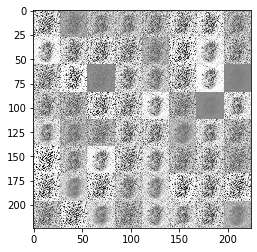

Train: Epoch: 1 | BCE: 0.27309 | KL Divergence: 4.31502
Val: Epoch: 1 | BCE: 0.26329 | KL Divergence: 3.83661
Train: Epoch: 2 | BCE: 0.25922 | KL Divergence: 3.46661
Val: Epoch: 2 | BCE: 0.25668 | KL Divergence: 3.09768
Train: Epoch: 3 | BCE: 0.25474 | KL Divergence: 2.97687
Val: Epoch: 3 | BCE: 0.25214 | KL Divergence: 2.99686
Train: Epoch: 4 | BCE: 0.24709 | KL Divergence: 3.03410
Val: Epoch: 4 | BCE: 0.24651 | KL Divergence: 2.99545
Train: Epoch: 5 | BCE: 0.24748 | KL Divergence: 2.91578
Val: Epoch: 5 | BCE: 0.24198 | KL Divergence: 2.91580
Train: Epoch: 6 | BCE: 0.24237 | KL Divergence: 2.86677
Val: Epoch: 6 | BCE: 0.23791 | KL Divergence: 2.88195
Train: Epoch: 7 | BCE: 0.24045 | KL Divergence: 2.79731
Val: Epoch: 7 | BCE: 0.23769 | KL Divergence: 2.79987
Train: Epoch: 8 | BCE: 0.23814 | KL Divergence: 2.74996
Val: Epoch: 8 | BCE: 0.23466 | KL Divergence: 2.83989
Train: Epoch: 9 | BCE: 0.23579 | KL Divergence: 2.74801
Val: Epoch: 9 | BCE: 0.23266 | KL Divergence: 2.78357
Train: Epo

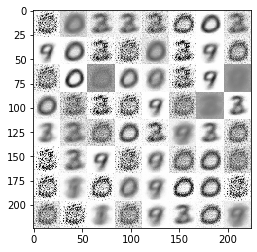

Train: Epoch: 11 | BCE: 0.23318 | KL Divergence: 2.72921
Val: Epoch: 11 | BCE: 0.22712 | KL Divergence: 2.85144
Train: Epoch: 12 | BCE: 0.23169 | KL Divergence: 2.74437
Val: Epoch: 12 | BCE: 0.23049 | KL Divergence: 2.79636
Train: Epoch: 13 | BCE: 0.23269 | KL Divergence: 2.70423
Val: Epoch: 13 | BCE: 0.23081 | KL Divergence: 2.72471
Train: Epoch: 14 | BCE: 0.22991 | KL Divergence: 2.76260
Val: Epoch: 14 | BCE: 0.22907 | KL Divergence: 2.72832
Train: Epoch: 15 | BCE: 0.22685 | KL Divergence: 2.78911
Val: Epoch: 15 | BCE: 0.22823 | KL Divergence: 2.74140
Train: Epoch: 16 | BCE: 0.22818 | KL Divergence: 2.75453
Val: Epoch: 16 | BCE: 0.22428 | KL Divergence: 2.74537
Train: Epoch: 17 | BCE: 0.22613 | KL Divergence: 2.75638
Val: Epoch: 17 | BCE: 0.22344 | KL Divergence: 2.81813
Train: Epoch: 18 | BCE: 0.22517 | KL Divergence: 2.76032
Val: Epoch: 18 | BCE: 0.22309 | KL Divergence: 2.77263
Train: Epoch: 19 | BCE: 0.22280 | KL Divergence: 2.78228
Val: Epoch: 19 | BCE: 0.22448 | KL Divergence: 

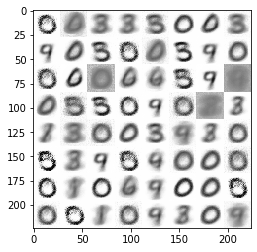

Train: Epoch: 21 | BCE: 0.21720 | KL Divergence: 2.81270
Val: Epoch: 21 | BCE: 0.22227 | KL Divergence: 2.83560
Train: Epoch: 22 | BCE: 0.22013 | KL Divergence: 2.78711
Val: Epoch: 22 | BCE: 0.21842 | KL Divergence: 2.82267
Train: Epoch: 23 | BCE: 0.22050 | KL Divergence: 2.80109
Val: Epoch: 23 | BCE: 0.21987 | KL Divergence: 2.85357
Train: Epoch: 24 | BCE: 0.21808 | KL Divergence: 2.79665
Val: Epoch: 24 | BCE: 0.21917 | KL Divergence: 2.84610
Train: Epoch: 25 | BCE: 0.21726 | KL Divergence: 2.79457
Val: Epoch: 25 | BCE: 0.21711 | KL Divergence: 2.83220
Train: Epoch: 26 | BCE: 0.21608 | KL Divergence: 2.80113
Val: Epoch: 26 | BCE: 0.21969 | KL Divergence: 2.79227
Train: Epoch: 27 | BCE: 0.21802 | KL Divergence: 2.79394
Val: Epoch: 27 | BCE: 0.21751 | KL Divergence: 2.82636
Train: Epoch: 28 | BCE: 0.21924 | KL Divergence: 2.79622
Val: Epoch: 28 | BCE: 0.21799 | KL Divergence: 2.89341
Train: Epoch: 29 | BCE: 0.21966 | KL Divergence: 2.80366
Val: Epoch: 29 | BCE: 0.21644 | KL Divergence: 

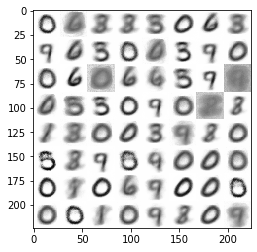

Train: Epoch: 31 | BCE: 0.21428 | KL Divergence: 2.83354
Val: Epoch: 31 | BCE: 0.21592 | KL Divergence: 2.87954
Train: Epoch: 32 | BCE: 0.21463 | KL Divergence: 2.82935
Val: Epoch: 32 | BCE: 0.21600 | KL Divergence: 2.89338
Train: Epoch: 33 | BCE: 0.21440 | KL Divergence: 2.78870
Val: Epoch: 33 | BCE: 0.21646 | KL Divergence: 2.93407
Train: Epoch: 34 | BCE: 0.21588 | KL Divergence: 2.80850
Val: Epoch: 34 | BCE: 0.21395 | KL Divergence: 2.85730
Train: Epoch: 35 | BCE: 0.21050 | KL Divergence: 2.86379
Val: Epoch: 35 | BCE: 0.21477 | KL Divergence: 2.84034
Train: Epoch: 36 | BCE: 0.21324 | KL Divergence: 2.81188
Val: Epoch: 36 | BCE: 0.21519 | KL Divergence: 2.89914
Train: Epoch: 37 | BCE: 0.21047 | KL Divergence: 2.87448
Val: Epoch: 37 | BCE: 0.21495 | KL Divergence: 2.83828
Train: Epoch: 38 | BCE: 0.21093 | KL Divergence: 2.84213
Val: Epoch: 38 | BCE: 0.21535 | KL Divergence: 2.88455
Train: Epoch: 39 | BCE: 0.21006 | KL Divergence: 2.83945
Val: Epoch: 39 | BCE: 0.21364 | KL Divergence: 

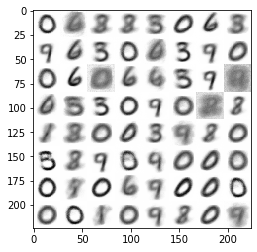

Train: Epoch: 41 | BCE: 0.21048 | KL Divergence: 2.87064
Val: Epoch: 41 | BCE: 0.21171 | KL Divergence: 2.89746
Train: Epoch: 42 | BCE: 0.20802 | KL Divergence: 2.88801
Val: Epoch: 42 | BCE: 0.21190 | KL Divergence: 2.91867
Train: Epoch: 43 | BCE: 0.20956 | KL Divergence: 2.88403
Val: Epoch: 43 | BCE: 0.20871 | KL Divergence: 2.86056
Train: Epoch: 44 | BCE: 0.20915 | KL Divergence: 2.84583
Val: Epoch: 44 | BCE: 0.21070 | KL Divergence: 2.86449
Train: Epoch: 45 | BCE: 0.20531 | KL Divergence: 2.88237
Val: Epoch: 45 | BCE: 0.21072 | KL Divergence: 2.91693
Train: Epoch: 46 | BCE: 0.20717 | KL Divergence: 2.85968
Val: Epoch: 46 | BCE: 0.20909 | KL Divergence: 2.88332
Train: Epoch: 47 | BCE: 0.20838 | KL Divergence: 2.85616
Val: Epoch: 47 | BCE: 0.21094 | KL Divergence: 2.87728
Train: Epoch: 48 | BCE: 0.20585 | KL Divergence: 2.88168
Val: Epoch: 48 | BCE: 0.20702 | KL Divergence: 2.86463
Train: Epoch: 49 | BCE: 0.20681 | KL Divergence: 2.82174
Val: Epoch: 49 | BCE: 0.20636 | KL Divergence: 

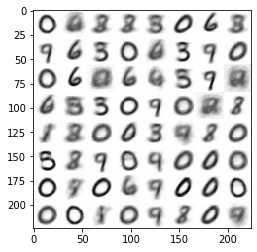

Train: Epoch: 51 | BCE: 0.20465 | KL Divergence: 2.86396
Val: Epoch: 51 | BCE: 0.20934 | KL Divergence: 2.86296
Train: Epoch: 52 | BCE: 0.20453 | KL Divergence: 2.86986
Val: Epoch: 52 | BCE: 0.20459 | KL Divergence: 2.92532
Train: Epoch: 53 | BCE: 0.20586 | KL Divergence: 2.86524
Val: Epoch: 53 | BCE: 0.20611 | KL Divergence: 2.88964
Train: Epoch: 54 | BCE: 0.20345 | KL Divergence: 2.88093
Val: Epoch: 54 | BCE: 0.20582 | KL Divergence: 2.91767
Train: Epoch: 55 | BCE: 0.20382 | KL Divergence: 2.90378
Val: Epoch: 55 | BCE: 0.20605 | KL Divergence: 2.92379
Train: Epoch: 56 | BCE: 0.20404 | KL Divergence: 2.88242
Val: Epoch: 56 | BCE: 0.20433 | KL Divergence: 2.93068
Train: Epoch: 57 | BCE: 0.20509 | KL Divergence: 2.85558
Val: Epoch: 57 | BCE: 0.20490 | KL Divergence: 2.90166
Train: Epoch: 58 | BCE: 0.20259 | KL Divergence: 2.89883
Val: Epoch: 58 | BCE: 0.20500 | KL Divergence: 2.88815
Train: Epoch: 59 | BCE: 0.20199 | KL Divergence: 2.88582
Val: Epoch: 59 | BCE: 0.20248 | KL Divergence: 

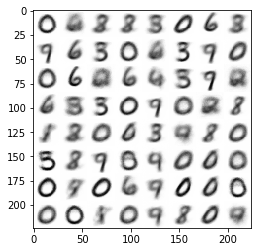

Train: Epoch: 61 | BCE: 0.20031 | KL Divergence: 2.90633
Val: Epoch: 61 | BCE: 0.20638 | KL Divergence: 2.92318
Train: Epoch: 62 | BCE: 0.20467 | KL Divergence: 2.87905
Val: Epoch: 62 | BCE: 0.20600 | KL Divergence: 2.87513
Train: Epoch: 63 | BCE: 0.20192 | KL Divergence: 2.89219
Val: Epoch: 63 | BCE: 0.20226 | KL Divergence: 2.91216
Train: Epoch: 64 | BCE: 0.20042 | KL Divergence: 2.87570
Val: Epoch: 64 | BCE: 0.20458 | KL Divergence: 2.94610
Train: Epoch: 65 | BCE: 0.20070 | KL Divergence: 2.89378
Val: Epoch: 65 | BCE: 0.20244 | KL Divergence: 2.89946
Train: Epoch: 66 | BCE: 0.19906 | KL Divergence: 2.93063
Val: Epoch: 66 | BCE: 0.20171 | KL Divergence: 2.94001
Train: Epoch: 67 | BCE: 0.19990 | KL Divergence: 2.91869
Val: Epoch: 67 | BCE: 0.19954 | KL Divergence: 2.99393
Train: Epoch: 68 | BCE: 0.19942 | KL Divergence: 2.90888
Val: Epoch: 68 | BCE: 0.19878 | KL Divergence: 2.92212
Train: Epoch: 69 | BCE: 0.19706 | KL Divergence: 2.91643
Val: Epoch: 69 | BCE: 0.20352 | KL Divergence: 

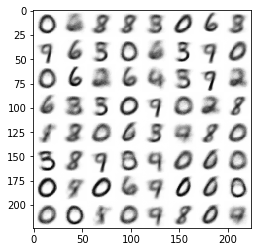

Train: Epoch: 71 | BCE: 0.19864 | KL Divergence: 2.93885
Val: Epoch: 71 | BCE: 0.20455 | KL Divergence: 2.96312
Train: Epoch: 72 | BCE: 0.20050 | KL Divergence: 2.90459
Val: Epoch: 72 | BCE: 0.20135 | KL Divergence: 2.99178
Train: Epoch: 73 | BCE: 0.19868 | KL Divergence: 2.92852
Val: Epoch: 73 | BCE: 0.20062 | KL Divergence: 2.98053
Train: Epoch: 74 | BCE: 0.19738 | KL Divergence: 2.95536
Val: Epoch: 74 | BCE: 0.20281 | KL Divergence: 2.91073
Train: Epoch: 75 | BCE: 0.19714 | KL Divergence: 2.93339
Val: Epoch: 75 | BCE: 0.20259 | KL Divergence: 2.92961
Train: Epoch: 76 | BCE: 0.19699 | KL Divergence: 2.96361
Val: Epoch: 76 | BCE: 0.20028 | KL Divergence: 2.99298
Train: Epoch: 77 | BCE: 0.19436 | KL Divergence: 3.00686
Val: Epoch: 77 | BCE: 0.20013 | KL Divergence: 3.01823
Train: Epoch: 78 | BCE: 0.19760 | KL Divergence: 2.94848
Val: Epoch: 78 | BCE: 0.19948 | KL Divergence: 3.00184
Train: Epoch: 79 | BCE: 0.19571 | KL Divergence: 2.96761
Val: Epoch: 79 | BCE: 0.20009 | KL Divergence: 

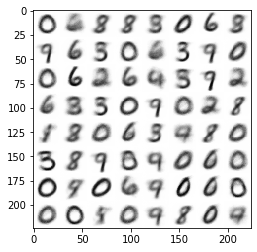

Train: Epoch: 81 | BCE: 0.19514 | KL Divergence: 2.96371
Val: Epoch: 81 | BCE: 0.19756 | KL Divergence: 2.98610
Train: Epoch: 82 | BCE: 0.19802 | KL Divergence: 2.95361
Val: Epoch: 82 | BCE: 0.19959 | KL Divergence: 3.00578
Train: Epoch: 83 | BCE: 0.19433 | KL Divergence: 2.99570
Val: Epoch: 83 | BCE: 0.19858 | KL Divergence: 2.99764
Train: Epoch: 84 | BCE: 0.19789 | KL Divergence: 2.96826
Val: Epoch: 84 | BCE: 0.19907 | KL Divergence: 2.98831
Train: Epoch: 85 | BCE: 0.19350 | KL Divergence: 3.00464
Val: Epoch: 85 | BCE: 0.19683 | KL Divergence: 3.04242
Train: Epoch: 86 | BCE: 0.19432 | KL Divergence: 2.99834
Val: Epoch: 86 | BCE: 0.20161 | KL Divergence: 3.01770
Train: Epoch: 87 | BCE: 0.19565 | KL Divergence: 2.97048
Val: Epoch: 87 | BCE: 0.19707 | KL Divergence: 3.00560
Train: Epoch: 88 | BCE: 0.19520 | KL Divergence: 2.99141
Val: Epoch: 88 | BCE: 0.19881 | KL Divergence: 3.03597
Train: Epoch: 89 | BCE: 0.19617 | KL Divergence: 3.00095
Val: Epoch: 89 | BCE: 0.19922 | KL Divergence: 

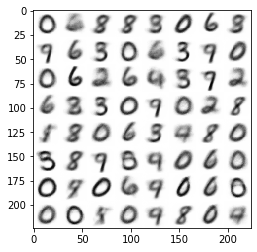

Train: Epoch: 91 | BCE: 0.19516 | KL Divergence: 3.03458
Val: Epoch: 91 | BCE: 0.19724 | KL Divergence: 3.06549
Train: Epoch: 92 | BCE: 0.19272 | KL Divergence: 3.03447
Val: Epoch: 92 | BCE: 0.19971 | KL Divergence: 3.02682
Train: Epoch: 93 | BCE: 0.19358 | KL Divergence: 3.02216
Val: Epoch: 93 | BCE: 0.19712 | KL Divergence: 3.03342
Train: Epoch: 94 | BCE: 0.19395 | KL Divergence: 3.00864
Val: Epoch: 94 | BCE: 0.19917 | KL Divergence: 3.04606
Train: Epoch: 95 | BCE: 0.19367 | KL Divergence: 3.00109
Val: Epoch: 95 | BCE: 0.19652 | KL Divergence: 3.02704
Train: Epoch: 96 | BCE: 0.19420 | KL Divergence: 3.02095
Val: Epoch: 96 | BCE: 0.19826 | KL Divergence: 3.01700
Train: Epoch: 97 | BCE: 0.19521 | KL Divergence: 3.03633
Val: Epoch: 97 | BCE: 0.19895 | KL Divergence: 3.03612
Train: Epoch: 98 | BCE: 0.19488 | KL Divergence: 3.02116
Val: Epoch: 98 | BCE: 0.19808 | KL Divergence: 3.05043
Train: Epoch: 99 | BCE: 0.19152 | KL Divergence: 3.08278
Val: Epoch: 99 | BCE: 0.19675 | KL Divergence: 

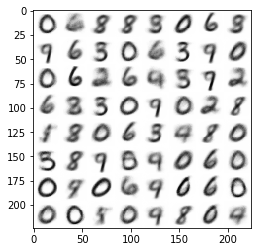

Train: Epoch: 101 | BCE: 0.19275 | KL Divergence: 3.04658
Val: Epoch: 101 | BCE: 0.19690 | KL Divergence: 3.03608
Train: Epoch: 102 | BCE: 0.18985 | KL Divergence: 3.03356
Val: Epoch: 102 | BCE: 0.19493 | KL Divergence: 3.05906
Train: Epoch: 103 | BCE: 0.19124 | KL Divergence: 3.02983
Val: Epoch: 103 | BCE: 0.19779 | KL Divergence: 3.00015
Train: Epoch: 104 | BCE: 0.19282 | KL Divergence: 3.05650
Val: Epoch: 104 | BCE: 0.19476 | KL Divergence: 3.05164
Train: Epoch: 105 | BCE: 0.19291 | KL Divergence: 3.06860
Val: Epoch: 105 | BCE: 0.19455 | KL Divergence: 3.09399
Train: Epoch: 106 | BCE: 0.19280 | KL Divergence: 3.08055
Val: Epoch: 106 | BCE: 0.19475 | KL Divergence: 3.08217
Train: Epoch: 107 | BCE: 0.18973 | KL Divergence: 3.08729
Val: Epoch: 107 | BCE: 0.19732 | KL Divergence: 3.05345
Train: Epoch: 108 | BCE: 0.19299 | KL Divergence: 3.05885
Val: Epoch: 108 | BCE: 0.19366 | KL Divergence: 3.08958
Train: Epoch: 109 | BCE: 0.19114 | KL Divergence: 3.06087
Val: Epoch: 109 | BCE: 0.19458

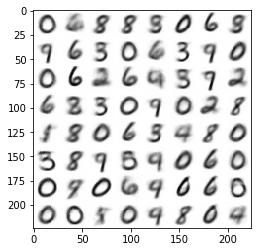

Train: Epoch: 111 | BCE: 0.19213 | KL Divergence: 3.05706
Val: Epoch: 111 | BCE: 0.19587 | KL Divergence: 3.05518
Train: Epoch: 112 | BCE: 0.19049 | KL Divergence: 3.07047
Val: Epoch: 112 | BCE: 0.19589 | KL Divergence: 3.09325
Train: Epoch: 113 | BCE: 0.19039 | KL Divergence: 3.06152
Val: Epoch: 113 | BCE: 0.19414 | KL Divergence: 3.11951
Train: Epoch: 114 | BCE: 0.19256 | KL Divergence: 3.07740
Val: Epoch: 114 | BCE: 0.19399 | KL Divergence: 3.06409
Train: Epoch: 115 | BCE: 0.19130 | KL Divergence: 3.07615
Val: Epoch: 115 | BCE: 0.19615 | KL Divergence: 3.11586
Train: Epoch: 116 | BCE: 0.19209 | KL Divergence: 3.03552
Val: Epoch: 116 | BCE: 0.19377 | KL Divergence: 3.09736
Train: Epoch: 117 | BCE: 0.18923 | KL Divergence: 3.09855
Val: Epoch: 117 | BCE: 0.19349 | KL Divergence: 3.11043
Train: Epoch: 118 | BCE: 0.19286 | KL Divergence: 3.08007
Val: Epoch: 118 | BCE: 0.19407 | KL Divergence: 3.09446
Train: Epoch: 119 | BCE: 0.19130 | KL Divergence: 3.08269
Val: Epoch: 119 | BCE: 0.19301

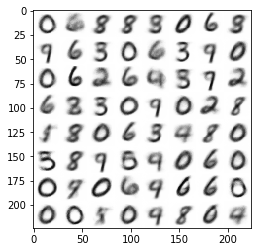

Train: Epoch: 121 | BCE: 0.19018 | KL Divergence: 3.09800
Val: Epoch: 121 | BCE: 0.19264 | KL Divergence: 3.08481
Train: Epoch: 122 | BCE: 0.19168 | KL Divergence: 3.09370
Val: Epoch: 122 | BCE: 0.19599 | KL Divergence: 3.06981
Train: Epoch: 123 | BCE: 0.19114 | KL Divergence: 3.10421
Val: Epoch: 123 | BCE: 0.19250 | KL Divergence: 3.14507
Train: Epoch: 124 | BCE: 0.18990 | KL Divergence: 3.08027
Val: Epoch: 124 | BCE: 0.19680 | KL Divergence: 3.10064
Train: Epoch: 125 | BCE: 0.19058 | KL Divergence: 3.09601
Val: Epoch: 125 | BCE: 0.19405 | KL Divergence: 3.10323
Train: Epoch: 126 | BCE: 0.18879 | KL Divergence: 3.12057
Val: Epoch: 126 | BCE: 0.19317 | KL Divergence: 3.09676
Train: Epoch: 127 | BCE: 0.19108 | KL Divergence: 3.10747
Val: Epoch: 127 | BCE: 0.19329 | KL Divergence: 3.15520
Train: Epoch: 128 | BCE: 0.18936 | KL Divergence: 3.08693
Val: Epoch: 128 | BCE: 0.19325 | KL Divergence: 3.13122
Train: Epoch: 129 | BCE: 0.18870 | KL Divergence: 3.09823
Val: Epoch: 129 | BCE: 0.19208

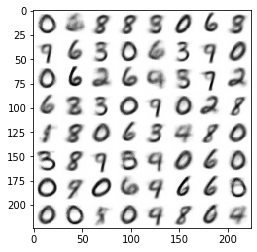

Train: Epoch: 131 | BCE: 0.18958 | KL Divergence: 3.11782
Val: Epoch: 131 | BCE: 0.19264 | KL Divergence: 3.14030
Train: Epoch: 132 | BCE: 0.18873 | KL Divergence: 3.12352
Val: Epoch: 132 | BCE: 0.19308 | KL Divergence: 3.12685
Train: Epoch: 133 | BCE: 0.18869 | KL Divergence: 3.14233
Val: Epoch: 133 | BCE: 0.19641 | KL Divergence: 3.13107
Train: Epoch: 134 | BCE: 0.18712 | KL Divergence: 3.14196
Val: Epoch: 134 | BCE: 0.19265 | KL Divergence: 3.18645
Train: Epoch: 135 | BCE: 0.18874 | KL Divergence: 3.11751
Val: Epoch: 135 | BCE: 0.19286 | KL Divergence: 3.11693
Train: Epoch: 136 | BCE: 0.18933 | KL Divergence: 3.11604
Val: Epoch: 136 | BCE: 0.19398 | KL Divergence: 3.13852
Train: Epoch: 137 | BCE: 0.18777 | KL Divergence: 3.10561
Val: Epoch: 137 | BCE: 0.19352 | KL Divergence: 3.13625
Train: Epoch: 138 | BCE: 0.18927 | KL Divergence: 3.11932
Val: Epoch: 138 | BCE: 0.18939 | KL Divergence: 3.18990
Train: Epoch: 139 | BCE: 0.18958 | KL Divergence: 3.10750
Val: Epoch: 139 | BCE: 0.19285

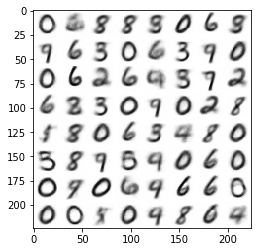

Train: Epoch: 141 | BCE: 0.18566 | KL Divergence: 3.12827
Val: Epoch: 141 | BCE: 0.19245 | KL Divergence: 3.13764
Train: Epoch: 142 | BCE: 0.18866 | KL Divergence: 3.11588
Val: Epoch: 142 | BCE: 0.19098 | KL Divergence: 3.14561
Train: Epoch: 143 | BCE: 0.18841 | KL Divergence: 3.11942
Val: Epoch: 143 | BCE: 0.19289 | KL Divergence: 3.11624
Train: Epoch: 144 | BCE: 0.18796 | KL Divergence: 3.16001
Val: Epoch: 144 | BCE: 0.18950 | KL Divergence: 3.19084
Train: Epoch: 145 | BCE: 0.18701 | KL Divergence: 3.16635
Val: Epoch: 145 | BCE: 0.19230 | KL Divergence: 3.15992
Train: Epoch: 146 | BCE: 0.18688 | KL Divergence: 3.11674
Val: Epoch: 146 | BCE: 0.18997 | KL Divergence: 3.16689
Train: Epoch: 147 | BCE: 0.19018 | KL Divergence: 3.11489
Val: Epoch: 147 | BCE: 0.19603 | KL Divergence: 3.10075
Train: Epoch: 148 | BCE: 0.18920 | KL Divergence: 3.12118
Val: Epoch: 148 | BCE: 0.19231 | KL Divergence: 3.16275
Train: Epoch: 149 | BCE: 0.18616 | KL Divergence: 3.12926
Val: Epoch: 149 | BCE: 0.19280

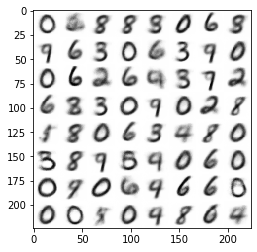

Train: Epoch: 151 | BCE: 0.18671 | KL Divergence: 3.16441
Val: Epoch: 151 | BCE: 0.19385 | KL Divergence: 3.19665
Train: Epoch: 152 | BCE: 0.18911 | KL Divergence: 3.15788
Val: Epoch: 152 | BCE: 0.19276 | KL Divergence: 3.17696
Train: Epoch: 153 | BCE: 0.18541 | KL Divergence: 3.16946
Val: Epoch: 153 | BCE: 0.19462 | KL Divergence: 3.16107
Train: Epoch: 154 | BCE: 0.18635 | KL Divergence: 3.17202
Val: Epoch: 154 | BCE: 0.18864 | KL Divergence: 3.19268
Train: Epoch: 155 | BCE: 0.18545 | KL Divergence: 3.16148
Val: Epoch: 155 | BCE: 0.19092 | KL Divergence: 3.21236
Train: Epoch: 156 | BCE: 0.18841 | KL Divergence: 3.16233
Val: Epoch: 156 | BCE: 0.19249 | KL Divergence: 3.17833
Train: Epoch: 157 | BCE: 0.18865 | KL Divergence: 3.15776
Val: Epoch: 157 | BCE: 0.19335 | KL Divergence: 3.13884
Train: Epoch: 158 | BCE: 0.18724 | KL Divergence: 3.15597
Val: Epoch: 158 | BCE: 0.19119 | KL Divergence: 3.17790
Train: Epoch: 159 | BCE: 0.18648 | KL Divergence: 3.17414
Val: Epoch: 159 | BCE: 0.19021

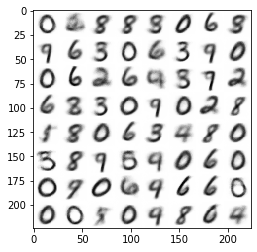

Train: Epoch: 161 | BCE: 0.18743 | KL Divergence: 3.18503
Val: Epoch: 161 | BCE: 0.19131 | KL Divergence: 3.22102
Train: Epoch: 162 | BCE: 0.18576 | KL Divergence: 3.17828
Val: Epoch: 162 | BCE: 0.19161 | KL Divergence: 3.17089
Train: Epoch: 163 | BCE: 0.18769 | KL Divergence: 3.14859
Val: Epoch: 163 | BCE: 0.19024 | KL Divergence: 3.17508
Train: Epoch: 164 | BCE: 0.18794 | KL Divergence: 3.15266
Val: Epoch: 164 | BCE: 0.19126 | KL Divergence: 3.16153
Train: Epoch: 165 | BCE: 0.18555 | KL Divergence: 3.17049
Val: Epoch: 165 | BCE: 0.19217 | KL Divergence: 3.17238
Train: Epoch: 166 | BCE: 0.18802 | KL Divergence: 3.15305
Val: Epoch: 166 | BCE: 0.18934 | KL Divergence: 3.19917
Train: Epoch: 167 | BCE: 0.18383 | KL Divergence: 3.20733
Val: Epoch: 167 | BCE: 0.18872 | KL Divergence: 3.23612
Train: Epoch: 168 | BCE: 0.18291 | KL Divergence: 3.18761
Val: Epoch: 168 | BCE: 0.19017 | KL Divergence: 3.21466
Train: Epoch: 169 | BCE: 0.18441 | KL Divergence: 3.18353
Val: Epoch: 169 | BCE: 0.19185

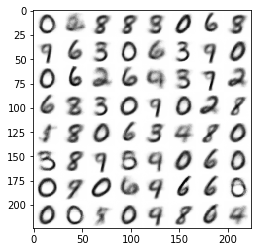

Train: Epoch: 171 | BCE: 0.18436 | KL Divergence: 3.18046
Val: Epoch: 171 | BCE: 0.19103 | KL Divergence: 3.17656
Train: Epoch: 172 | BCE: 0.18617 | KL Divergence: 3.19220
Val: Epoch: 172 | BCE: 0.18852 | KL Divergence: 3.22493
Train: Epoch: 173 | BCE: 0.18649 | KL Divergence: 3.17031
Val: Epoch: 173 | BCE: 0.18963 | KL Divergence: 3.19745
Train: Epoch: 174 | BCE: 0.18535 | KL Divergence: 3.18705
Val: Epoch: 174 | BCE: 0.18968 | KL Divergence: 3.19668
Train: Epoch: 175 | BCE: 0.18395 | KL Divergence: 3.20809
Val: Epoch: 175 | BCE: 0.19127 | KL Divergence: 3.20967
Train: Epoch: 176 | BCE: 0.18610 | KL Divergence: 3.17041
Val: Epoch: 176 | BCE: 0.18870 | KL Divergence: 3.21170
Train: Epoch: 177 | BCE: 0.18762 | KL Divergence: 3.16695
Val: Epoch: 177 | BCE: 0.19099 | KL Divergence: 3.22087
Train: Epoch: 178 | BCE: 0.18478 | KL Divergence: 3.20296
Val: Epoch: 178 | BCE: 0.19064 | KL Divergence: 3.21146
Train: Epoch: 179 | BCE: 0.18480 | KL Divergence: 3.20036
Val: Epoch: 179 | BCE: 0.19062

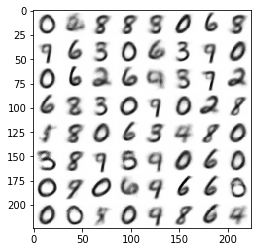

Train: Epoch: 181 | BCE: 0.18517 | KL Divergence: 3.18356
Val: Epoch: 181 | BCE: 0.18906 | KL Divergence: 3.21046
Train: Epoch: 182 | BCE: 0.18404 | KL Divergence: 3.20478
Val: Epoch: 182 | BCE: 0.18718 | KL Divergence: 3.25653
Train: Epoch: 183 | BCE: 0.18717 | KL Divergence: 3.15634
Val: Epoch: 183 | BCE: 0.19164 | KL Divergence: 3.21023
Train: Epoch: 184 | BCE: 0.18341 | KL Divergence: 3.20451
Val: Epoch: 184 | BCE: 0.18978 | KL Divergence: 3.22619
Train: Epoch: 185 | BCE: 0.18470 | KL Divergence: 3.20078
Val: Epoch: 185 | BCE: 0.18876 | KL Divergence: 3.22046
Train: Epoch: 186 | BCE: 0.18738 | KL Divergence: 3.16378
Val: Epoch: 186 | BCE: 0.18953 | KL Divergence: 3.19208
Train: Epoch: 187 | BCE: 0.18363 | KL Divergence: 3.18859
Val: Epoch: 187 | BCE: 0.18849 | KL Divergence: 3.19813
Train: Epoch: 188 | BCE: 0.18488 | KL Divergence: 3.21766
Val: Epoch: 188 | BCE: 0.19023 | KL Divergence: 3.19001
Train: Epoch: 189 | BCE: 0.18472 | KL Divergence: 3.23105
Val: Epoch: 189 | BCE: 0.18935

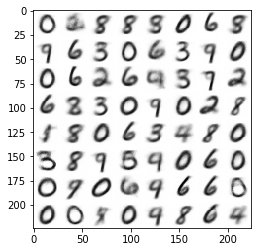

Train: Epoch: 191 | BCE: 0.18382 | KL Divergence: 3.21507
Val: Epoch: 191 | BCE: 0.19134 | KL Divergence: 3.24460
Train: Epoch: 192 | BCE: 0.18276 | KL Divergence: 3.21998
Val: Epoch: 192 | BCE: 0.19054 | KL Divergence: 3.23743
Train: Epoch: 193 | BCE: 0.18525 | KL Divergence: 3.18842
Val: Epoch: 193 | BCE: 0.18992 | KL Divergence: 3.21585
Train: Epoch: 194 | BCE: 0.18529 | KL Divergence: 3.20453
Val: Epoch: 194 | BCE: 0.18711 | KL Divergence: 3.24332
Train: Epoch: 195 | BCE: 0.18234 | KL Divergence: 3.23426
Val: Epoch: 195 | BCE: 0.19199 | KL Divergence: 3.22162
Train: Epoch: 196 | BCE: 0.18393 | KL Divergence: 3.21285
Val: Epoch: 196 | BCE: 0.18755 | KL Divergence: 3.25745
Train: Epoch: 197 | BCE: 0.18504 | KL Divergence: 3.21954
Val: Epoch: 197 | BCE: 0.18770 | KL Divergence: 3.21612
Train: Epoch: 198 | BCE: 0.18543 | KL Divergence: 3.18535
Val: Epoch: 198 | BCE: 0.18968 | KL Divergence: 3.21763
Train: Epoch: 199 | BCE: 0.18417 | KL Divergence: 3.20589
Val: Epoch: 199 | BCE: 0.18847

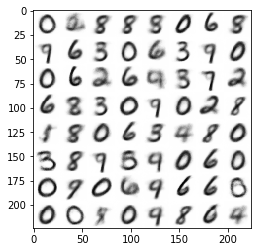

Train: Epoch: 201 | BCE: 0.18542 | KL Divergence: 3.19390
Val: Epoch: 201 | BCE: 0.18685 | KL Divergence: 3.25074
Train: Epoch: 202 | BCE: 0.18368 | KL Divergence: 3.21108
Val: Epoch: 202 | BCE: 0.18814 | KL Divergence: 3.24913
Train: Epoch: 203 | BCE: 0.18117 | KL Divergence: 3.24052
Val: Epoch: 203 | BCE: 0.18976 | KL Divergence: 3.27502
Train: Epoch: 204 | BCE: 0.18309 | KL Divergence: 3.23499
Val: Epoch: 204 | BCE: 0.18608 | KL Divergence: 3.30304
Train: Epoch: 205 | BCE: 0.18340 | KL Divergence: 3.24143
Val: Epoch: 205 | BCE: 0.18666 | KL Divergence: 3.30060
Train: Epoch: 206 | BCE: 0.18263 | KL Divergence: 3.22733
Val: Epoch: 206 | BCE: 0.18978 | KL Divergence: 3.25734
Train: Epoch: 207 | BCE: 0.18445 | KL Divergence: 3.22946
Val: Epoch: 207 | BCE: 0.18776 | KL Divergence: 3.26634
Train: Epoch: 208 | BCE: 0.18391 | KL Divergence: 3.23062
Val: Epoch: 208 | BCE: 0.18782 | KL Divergence: 3.26503
Train: Epoch: 209 | BCE: 0.18461 | KL Divergence: 3.21985
Val: Epoch: 209 | BCE: 0.18908

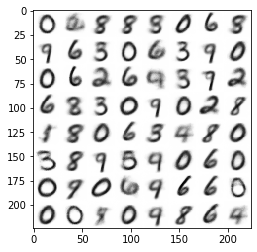

Train: Epoch: 211 | BCE: 0.17889 | KL Divergence: 3.25265
Val: Epoch: 211 | BCE: 0.18787 | KL Divergence: 3.26234
Train: Epoch: 212 | BCE: 0.18472 | KL Divergence: 3.22459
Val: Epoch: 212 | BCE: 0.18680 | KL Divergence: 3.29094
Train: Epoch: 213 | BCE: 0.18236 | KL Divergence: 3.25076
Val: Epoch: 213 | BCE: 0.18909 | KL Divergence: 3.27864
Train: Epoch: 214 | BCE: 0.18399 | KL Divergence: 3.23738
Val: Epoch: 214 | BCE: 0.18713 | KL Divergence: 3.25246
Train: Epoch: 215 | BCE: 0.18220 | KL Divergence: 3.22875
Val: Epoch: 215 | BCE: 0.18902 | KL Divergence: 3.25272
Train: Epoch: 216 | BCE: 0.18201 | KL Divergence: 3.24096
Val: Epoch: 216 | BCE: 0.18652 | KL Divergence: 3.24602
Train: Epoch: 217 | BCE: 0.18227 | KL Divergence: 3.23752
Val: Epoch: 217 | BCE: 0.18700 | KL Divergence: 3.26057
Train: Epoch: 218 | BCE: 0.18426 | KL Divergence: 3.22495
Val: Epoch: 218 | BCE: 0.18703 | KL Divergence: 3.27992
Train: Epoch: 219 | BCE: 0.18275 | KL Divergence: 3.25603
Val: Epoch: 219 | BCE: 0.18748

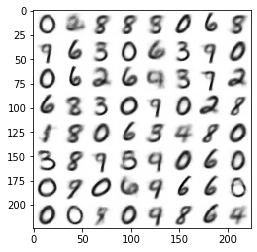

Train: Epoch: 221 | BCE: 0.18455 | KL Divergence: 3.25686
Val: Epoch: 221 | BCE: 0.18779 | KL Divergence: 3.26981
Train: Epoch: 222 | BCE: 0.18210 | KL Divergence: 3.23277
Val: Epoch: 222 | BCE: 0.19157 | KL Divergence: 3.27813
Train: Epoch: 223 | BCE: 0.18308 | KL Divergence: 3.24314
Val: Epoch: 223 | BCE: 0.18552 | KL Divergence: 3.29816
Train: Epoch: 224 | BCE: 0.18187 | KL Divergence: 3.25112
Val: Epoch: 224 | BCE: 0.18888 | KL Divergence: 3.26947
Train: Epoch: 225 | BCE: 0.18095 | KL Divergence: 3.26617
Val: Epoch: 225 | BCE: 0.18816 | KL Divergence: 3.32043
Train: Epoch: 226 | BCE: 0.18217 | KL Divergence: 3.27689
Val: Epoch: 226 | BCE: 0.18492 | KL Divergence: 3.28863
Train: Epoch: 227 | BCE: 0.18213 | KL Divergence: 3.24214
Val: Epoch: 227 | BCE: 0.18647 | KL Divergence: 3.26481
Train: Epoch: 228 | BCE: 0.18035 | KL Divergence: 3.27307
Val: Epoch: 228 | BCE: 0.18680 | KL Divergence: 3.27196
Train: Epoch: 229 | BCE: 0.18419 | KL Divergence: 3.24197
Val: Epoch: 229 | BCE: 0.18835

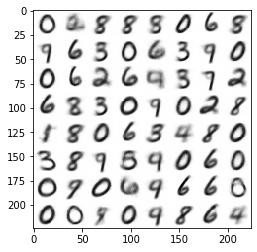

Train: Epoch: 231 | BCE: 0.18182 | KL Divergence: 3.28147
Val: Epoch: 231 | BCE: 0.18737 | KL Divergence: 3.28132
Train: Epoch: 232 | BCE: 0.18273 | KL Divergence: 3.26088
Val: Epoch: 232 | BCE: 0.18952 | KL Divergence: 3.25563
Train: Epoch: 233 | BCE: 0.18191 | KL Divergence: 3.27781
Val: Epoch: 233 | BCE: 0.18482 | KL Divergence: 3.27240
Train: Epoch: 234 | BCE: 0.18172 | KL Divergence: 3.26295
Val: Epoch: 234 | BCE: 0.18740 | KL Divergence: 3.28948
Train: Epoch: 235 | BCE: 0.17923 | KL Divergence: 3.29968
Val: Epoch: 235 | BCE: 0.18965 | KL Divergence: 3.29537
Train: Epoch: 236 | BCE: 0.18349 | KL Divergence: 3.27307
Val: Epoch: 236 | BCE: 0.18750 | KL Divergence: 3.29009
Train: Epoch: 237 | BCE: 0.18263 | KL Divergence: 3.25132
Val: Epoch: 237 | BCE: 0.18841 | KL Divergence: 3.24070
Train: Epoch: 238 | BCE: 0.17979 | KL Divergence: 3.29184
Val: Epoch: 238 | BCE: 0.18624 | KL Divergence: 3.28300
Train: Epoch: 239 | BCE: 0.18260 | KL Divergence: 3.24877
Val: Epoch: 239 | BCE: 0.18501

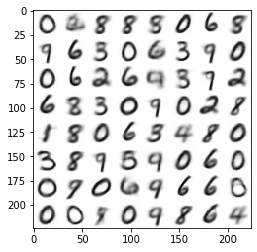

Train: Epoch: 241 | BCE: 0.18093 | KL Divergence: 3.27905
Val: Epoch: 241 | BCE: 0.18591 | KL Divergence: 3.29284
Train: Epoch: 242 | BCE: 0.17956 | KL Divergence: 3.29999
Val: Epoch: 242 | BCE: 0.18768 | KL Divergence: 3.28456
Train: Epoch: 243 | BCE: 0.18372 | KL Divergence: 3.24976
Val: Epoch: 243 | BCE: 0.18591 | KL Divergence: 3.31546
Train: Epoch: 244 | BCE: 0.18052 | KL Divergence: 3.27910
Val: Epoch: 244 | BCE: 0.18584 | KL Divergence: 3.30458
Train: Epoch: 245 | BCE: 0.18122 | KL Divergence: 3.27649
Val: Epoch: 245 | BCE: 0.18639 | KL Divergence: 3.31558
Train: Epoch: 246 | BCE: 0.18097 | KL Divergence: 3.29837
Val: Epoch: 246 | BCE: 0.18743 | KL Divergence: 3.29835
Train: Epoch: 247 | BCE: 0.17959 | KL Divergence: 3.30295
Val: Epoch: 247 | BCE: 0.18810 | KL Divergence: 3.33335
Train: Epoch: 248 | BCE: 0.17932 | KL Divergence: 3.31225
Val: Epoch: 248 | BCE: 0.18709 | KL Divergence: 3.28148
Train: Epoch: 249 | BCE: 0.17909 | KL Divergence: 3.29587
Val: Epoch: 249 | BCE: 0.18740

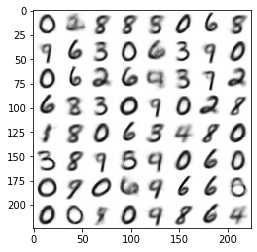

Train: Epoch: 251 | BCE: 0.17998 | KL Divergence: 3.28152
Val: Epoch: 251 | BCE: 0.18458 | KL Divergence: 3.31791
Train: Epoch: 252 | BCE: 0.18184 | KL Divergence: 3.28014
Val: Epoch: 252 | BCE: 0.18754 | KL Divergence: 3.30852
Train: Epoch: 253 | BCE: 0.17839 | KL Divergence: 3.29834
Val: Epoch: 253 | BCE: 0.18666 | KL Divergence: 3.32548
Train: Epoch: 254 | BCE: 0.18341 | KL Divergence: 3.29513
Val: Epoch: 254 | BCE: 0.18471 | KL Divergence: 3.28542
Train: Epoch: 255 | BCE: 0.17942 | KL Divergence: 3.29217
Val: Epoch: 255 | BCE: 0.18596 | KL Divergence: 3.29655
Train: Epoch: 256 | BCE: 0.18215 | KL Divergence: 3.28770
Val: Epoch: 256 | BCE: 0.18336 | KL Divergence: 3.32458
Train: Epoch: 257 | BCE: 0.17907 | KL Divergence: 3.29588
Val: Epoch: 257 | BCE: 0.18791 | KL Divergence: 3.31559
Train: Epoch: 258 | BCE: 0.17864 | KL Divergence: 3.29994
Val: Epoch: 258 | BCE: 0.18500 | KL Divergence: 3.32945
Train: Epoch: 259 | BCE: 0.17771 | KL Divergence: 3.31054
Val: Epoch: 259 | BCE: 0.18588

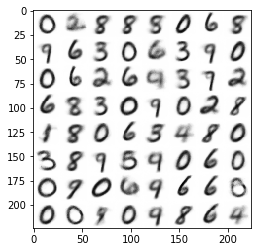

Train: Epoch: 261 | BCE: 0.17962 | KL Divergence: 3.29827
Val: Epoch: 261 | BCE: 0.18534 | KL Divergence: 3.30310
Train: Epoch: 262 | BCE: 0.18263 | KL Divergence: 3.29609
Val: Epoch: 262 | BCE: 0.18523 | KL Divergence: 3.30109
Train: Epoch: 263 | BCE: 0.17937 | KL Divergence: 3.31254
Val: Epoch: 263 | BCE: 0.18680 | KL Divergence: 3.29587
Train: Epoch: 264 | BCE: 0.17827 | KL Divergence: 3.30975
Val: Epoch: 264 | BCE: 0.18902 | KL Divergence: 3.30257
Train: Epoch: 265 | BCE: 0.18014 | KL Divergence: 3.29606
Val: Epoch: 265 | BCE: 0.18632 | KL Divergence: 3.31331
Train: Epoch: 266 | BCE: 0.18197 | KL Divergence: 3.27276
Val: Epoch: 266 | BCE: 0.18723 | KL Divergence: 3.34055
Train: Epoch: 267 | BCE: 0.17907 | KL Divergence: 3.31083
Val: Epoch: 267 | BCE: 0.18559 | KL Divergence: 3.34463
Train: Epoch: 268 | BCE: 0.18007 | KL Divergence: 3.31448
Val: Epoch: 268 | BCE: 0.18359 | KL Divergence: 3.33575
Train: Epoch: 269 | BCE: 0.17985 | KL Divergence: 3.32312
Val: Epoch: 269 | BCE: 0.18372

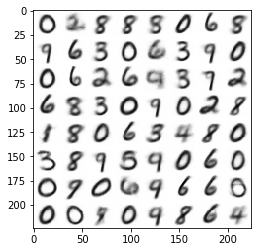

Train: Epoch: 271 | BCE: 0.17857 | KL Divergence: 3.30224
Val: Epoch: 271 | BCE: 0.18620 | KL Divergence: 3.32214
Train: Epoch: 272 | BCE: 0.17736 | KL Divergence: 3.33940
Val: Epoch: 272 | BCE: 0.18675 | KL Divergence: 3.32752
Train: Epoch: 273 | BCE: 0.17935 | KL Divergence: 3.33222
Val: Epoch: 273 | BCE: 0.18625 | KL Divergence: 3.35795
Train: Epoch: 274 | BCE: 0.17987 | KL Divergence: 3.32234
Val: Epoch: 274 | BCE: 0.18572 | KL Divergence: 3.32900
Train: Epoch: 275 | BCE: 0.18043 | KL Divergence: 3.31829
Val: Epoch: 275 | BCE: 0.18685 | KL Divergence: 3.32341
Train: Epoch: 276 | BCE: 0.17989 | KL Divergence: 3.31471
Val: Epoch: 276 | BCE: 0.18452 | KL Divergence: 3.34411
Train: Epoch: 277 | BCE: 0.18073 | KL Divergence: 3.31210
Val: Epoch: 277 | BCE: 0.18611 | KL Divergence: 3.28917
Train: Epoch: 278 | BCE: 0.17969 | KL Divergence: 3.33456
Val: Epoch: 278 | BCE: 0.18403 | KL Divergence: 3.38449
Train: Epoch: 279 | BCE: 0.17916 | KL Divergence: 3.32707
Val: Epoch: 279 | BCE: 0.18559

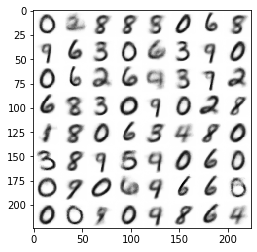

Train: Epoch: 281 | BCE: 0.18152 | KL Divergence: 3.31503
Val: Epoch: 281 | BCE: 0.18435 | KL Divergence: 3.34078
Train: Epoch: 282 | BCE: 0.17911 | KL Divergence: 3.33909
Val: Epoch: 282 | BCE: 0.18564 | KL Divergence: 3.37900
Train: Epoch: 283 | BCE: 0.17988 | KL Divergence: 3.32477
Val: Epoch: 283 | BCE: 0.18646 | KL Divergence: 3.34638
Train: Epoch: 284 | BCE: 0.17686 | KL Divergence: 3.34108
Val: Epoch: 284 | BCE: 0.18652 | KL Divergence: 3.33751
Train: Epoch: 285 | BCE: 0.18081 | KL Divergence: 3.32744
Val: Epoch: 285 | BCE: 0.18459 | KL Divergence: 3.34454
Train: Epoch: 286 | BCE: 0.17868 | KL Divergence: 3.32571
Val: Epoch: 286 | BCE: 0.18452 | KL Divergence: 3.35452
Train: Epoch: 287 | BCE: 0.17934 | KL Divergence: 3.33568
Val: Epoch: 287 | BCE: 0.18407 | KL Divergence: 3.32358
Train: Epoch: 288 | BCE: 0.17579 | KL Divergence: 3.36578
Val: Epoch: 288 | BCE: 0.18617 | KL Divergence: 3.36019
Train: Epoch: 289 | BCE: 0.17803 | KL Divergence: 3.35178
Val: Epoch: 289 | BCE: 0.18271

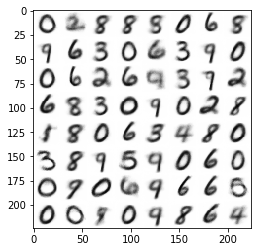

Train: Epoch: 291 | BCE: 0.17574 | KL Divergence: 3.34740
Val: Epoch: 291 | BCE: 0.18376 | KL Divergence: 3.34773
Train: Epoch: 292 | BCE: 0.17970 | KL Divergence: 3.32931
Val: Epoch: 292 | BCE: 0.18240 | KL Divergence: 3.34865
Train: Epoch: 293 | BCE: 0.17935 | KL Divergence: 3.32091
Val: Epoch: 293 | BCE: 0.18506 | KL Divergence: 3.39166
Train: Epoch: 294 | BCE: 0.17875 | KL Divergence: 3.36006
Val: Epoch: 294 | BCE: 0.18697 | KL Divergence: 3.35971
Train: Epoch: 295 | BCE: 0.17858 | KL Divergence: 3.34102
Val: Epoch: 295 | BCE: 0.18415 | KL Divergence: 3.33543
Train: Epoch: 296 | BCE: 0.18088 | KL Divergence: 3.34721
Val: Epoch: 296 | BCE: 0.18698 | KL Divergence: 3.35142
Train: Epoch: 297 | BCE: 0.17668 | KL Divergence: 3.34688
Val: Epoch: 297 | BCE: 0.18434 | KL Divergence: 3.37447
Train: Epoch: 298 | BCE: 0.17985 | KL Divergence: 3.34570
Val: Epoch: 298 | BCE: 0.18542 | KL Divergence: 3.34596
Train: Epoch: 299 | BCE: 0.17697 | KL Divergence: 3.34656
Val: Epoch: 299 | BCE: 0.18499

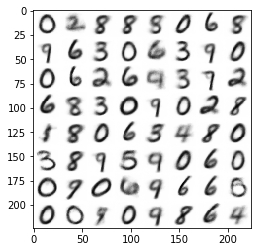

Train: Epoch: 301 | BCE: 0.17989 | KL Divergence: 3.36703
Val: Epoch: 301 | BCE: 0.18368 | KL Divergence: 3.36426
Train: Epoch: 302 | BCE: 0.17827 | KL Divergence: 3.34379
Val: Epoch: 302 | BCE: 0.18559 | KL Divergence: 3.36104
Train: Epoch: 303 | BCE: 0.17676 | KL Divergence: 3.35350
Val: Epoch: 303 | BCE: 0.18488 | KL Divergence: 3.38089
Train: Epoch: 304 | BCE: 0.17878 | KL Divergence: 3.34957
Val: Epoch: 304 | BCE: 0.18316 | KL Divergence: 3.36576
Train: Epoch: 305 | BCE: 0.17559 | KL Divergence: 3.37184
Val: Epoch: 305 | BCE: 0.18413 | KL Divergence: 3.34977
Train: Epoch: 306 | BCE: 0.17998 | KL Divergence: 3.33905
Val: Epoch: 306 | BCE: 0.18286 | KL Divergence: 3.34954
Train: Epoch: 307 | BCE: 0.17583 | KL Divergence: 3.35090
Val: Epoch: 307 | BCE: 0.18343 | KL Divergence: 3.37041
Train: Epoch: 308 | BCE: 0.17848 | KL Divergence: 3.35217
Val: Epoch: 308 | BCE: 0.18505 | KL Divergence: 3.34155
Train: Epoch: 309 | BCE: 0.17736 | KL Divergence: 3.35224
Val: Epoch: 309 | BCE: 0.18548

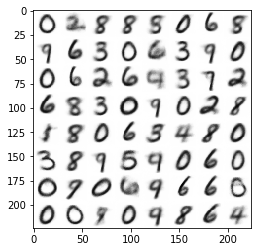

Train: Epoch: 311 | BCE: 0.17549 | KL Divergence: 3.36060
Val: Epoch: 311 | BCE: 0.18606 | KL Divergence: 3.39865
Train: Epoch: 312 | BCE: 0.17728 | KL Divergence: 3.38039
Val: Epoch: 312 | BCE: 0.18544 | KL Divergence: 3.37678
Train: Epoch: 313 | BCE: 0.17700 | KL Divergence: 3.36802
Val: Epoch: 313 | BCE: 0.18486 | KL Divergence: 3.40964
Train: Epoch: 314 | BCE: 0.17693 | KL Divergence: 3.37556
Val: Epoch: 314 | BCE: 0.18392 | KL Divergence: 3.37940
Train: Epoch: 315 | BCE: 0.17666 | KL Divergence: 3.39127
Val: Epoch: 315 | BCE: 0.18634 | KL Divergence: 3.38343
Train: Epoch: 316 | BCE: 0.17878 | KL Divergence: 3.37724
Val: Epoch: 316 | BCE: 0.18788 | KL Divergence: 3.37342
Train: Epoch: 317 | BCE: 0.17596 | KL Divergence: 3.38921
Val: Epoch: 317 | BCE: 0.18516 | KL Divergence: 3.39562
Train: Epoch: 318 | BCE: 0.17905 | KL Divergence: 3.38606
Val: Epoch: 318 | BCE: 0.18418 | KL Divergence: 3.36781
Train: Epoch: 319 | BCE: 0.17954 | KL Divergence: 3.36820
Val: Epoch: 319 | BCE: 0.18651

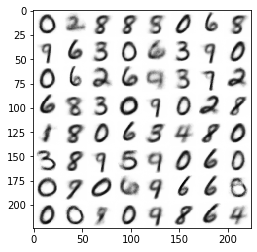

Train: Epoch: 321 | BCE: 0.17488 | KL Divergence: 3.37967
Val: Epoch: 321 | BCE: 0.18372 | KL Divergence: 3.40519
Train: Epoch: 322 | BCE: 0.17890 | KL Divergence: 3.37820
Val: Epoch: 322 | BCE: 0.18237 | KL Divergence: 3.39016
Train: Epoch: 323 | BCE: 0.17654 | KL Divergence: 3.38782
Val: Epoch: 323 | BCE: 0.18463 | KL Divergence: 3.39833
Train: Epoch: 324 | BCE: 0.17732 | KL Divergence: 3.36063
Val: Epoch: 324 | BCE: 0.18276 | KL Divergence: 3.42637
Train: Epoch: 325 | BCE: 0.17771 | KL Divergence: 3.39483
Val: Epoch: 325 | BCE: 0.18477 | KL Divergence: 3.41410
Train: Epoch: 326 | BCE: 0.17672 | KL Divergence: 3.37007
Val: Epoch: 326 | BCE: 0.18312 | KL Divergence: 3.40816
Train: Epoch: 327 | BCE: 0.17603 | KL Divergence: 3.38763
Val: Epoch: 327 | BCE: 0.18613 | KL Divergence: 3.39422
Train: Epoch: 328 | BCE: 0.17727 | KL Divergence: 3.38125
Val: Epoch: 328 | BCE: 0.18282 | KL Divergence: 3.38598
Train: Epoch: 329 | BCE: 0.17742 | KL Divergence: 3.37281
Val: Epoch: 329 | BCE: 0.18366

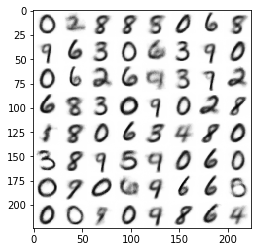

Train: Epoch: 331 | BCE: 0.17712 | KL Divergence: 3.40052
Val: Epoch: 331 | BCE: 0.18060 | KL Divergence: 3.39982
Train: Epoch: 332 | BCE: 0.17493 | KL Divergence: 3.41102
Val: Epoch: 332 | BCE: 0.18577 | KL Divergence: 3.42182
Train: Epoch: 333 | BCE: 0.17835 | KL Divergence: 3.38200
Val: Epoch: 333 | BCE: 0.18317 | KL Divergence: 3.41446
Train: Epoch: 334 | BCE: 0.17785 | KL Divergence: 3.39023
Val: Epoch: 334 | BCE: 0.18043 | KL Divergence: 3.41050
Train: Epoch: 335 | BCE: 0.17621 | KL Divergence: 3.41247
Val: Epoch: 335 | BCE: 0.18416 | KL Divergence: 3.41005
Train: Epoch: 336 | BCE: 0.17832 | KL Divergence: 3.37660
Val: Epoch: 336 | BCE: 0.18545 | KL Divergence: 3.41017
Train: Epoch: 337 | BCE: 0.17544 | KL Divergence: 3.40316
Val: Epoch: 337 | BCE: 0.18286 | KL Divergence: 3.41199
Train: Epoch: 338 | BCE: 0.17674 | KL Divergence: 3.40858
Val: Epoch: 338 | BCE: 0.18464 | KL Divergence: 3.39841
Train: Epoch: 339 | BCE: 0.17785 | KL Divergence: 3.39369
Val: Epoch: 339 | BCE: 0.18469

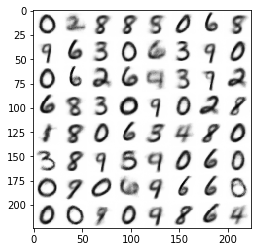

Train: Epoch: 341 | BCE: 0.17814 | KL Divergence: 3.40651
Val: Epoch: 341 | BCE: 0.18192 | KL Divergence: 3.39919
Train: Epoch: 342 | BCE: 0.17650 | KL Divergence: 3.37763
Val: Epoch: 342 | BCE: 0.18373 | KL Divergence: 3.41141
Train: Epoch: 343 | BCE: 0.17520 | KL Divergence: 3.40563
Val: Epoch: 343 | BCE: 0.18447 | KL Divergence: 3.42284
Train: Epoch: 344 | BCE: 0.17402 | KL Divergence: 3.39936
Val: Epoch: 344 | BCE: 0.18181 | KL Divergence: 3.40605
Train: Epoch: 345 | BCE: 0.17538 | KL Divergence: 3.41110
Val: Epoch: 345 | BCE: 0.18355 | KL Divergence: 3.42159
Train: Epoch: 346 | BCE: 0.17581 | KL Divergence: 3.42104
Val: Epoch: 346 | BCE: 0.18504 | KL Divergence: 3.39066
Train: Epoch: 347 | BCE: 0.17539 | KL Divergence: 3.41127
Val: Epoch: 347 | BCE: 0.18367 | KL Divergence: 3.42814
Train: Epoch: 348 | BCE: 0.17455 | KL Divergence: 3.42672
Val: Epoch: 348 | BCE: 0.18284 | KL Divergence: 3.44072
Train: Epoch: 349 | BCE: 0.17823 | KL Divergence: 3.41655
Val: Epoch: 349 | BCE: 0.18404

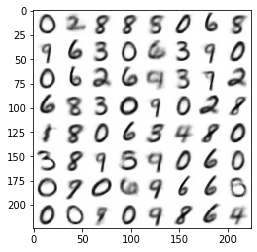

Train: Epoch: 351 | BCE: 0.17798 | KL Divergence: 3.40549
Val: Epoch: 351 | BCE: 0.18434 | KL Divergence: 3.41666
Train: Epoch: 352 | BCE: 0.17682 | KL Divergence: 3.40956
Val: Epoch: 352 | BCE: 0.18593 | KL Divergence: 3.42039
Train: Epoch: 353 | BCE: 0.17746 | KL Divergence: 3.40264
Val: Epoch: 353 | BCE: 0.18668 | KL Divergence: 3.41407
Train: Epoch: 354 | BCE: 0.17628 | KL Divergence: 3.40380
Val: Epoch: 354 | BCE: 0.18480 | KL Divergence: 3.40864
Train: Epoch: 355 | BCE: 0.17359 | KL Divergence: 3.42344
Val: Epoch: 355 | BCE: 0.18398 | KL Divergence: 3.43081
Train: Epoch: 356 | BCE: 0.17652 | KL Divergence: 3.40511
Val: Epoch: 356 | BCE: 0.18529 | KL Divergence: 3.42164
Train: Epoch: 357 | BCE: 0.17582 | KL Divergence: 3.42572
Val: Epoch: 357 | BCE: 0.18566 | KL Divergence: 3.40624
Train: Epoch: 358 | BCE: 0.17482 | KL Divergence: 3.41415
Val: Epoch: 358 | BCE: 0.18485 | KL Divergence: 3.41141
Train: Epoch: 359 | BCE: 0.17606 | KL Divergence: 3.40713
Val: Epoch: 359 | BCE: 0.18429

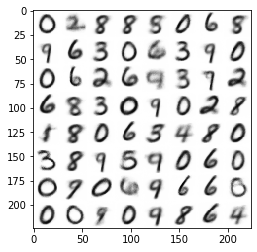

Train: Epoch: 361 | BCE: 0.17439 | KL Divergence: 3.39118
Val: Epoch: 361 | BCE: 0.18235 | KL Divergence: 3.43629
Train: Epoch: 362 | BCE: 0.17560 | KL Divergence: 3.44035
Val: Epoch: 362 | BCE: 0.18311 | KL Divergence: 3.47442
Train: Epoch: 363 | BCE: 0.17181 | KL Divergence: 3.46656
Val: Epoch: 363 | BCE: 0.18562 | KL Divergence: 3.43871
Train: Epoch: 364 | BCE: 0.17590 | KL Divergence: 3.40555
Val: Epoch: 364 | BCE: 0.18570 | KL Divergence: 3.43416
Train: Epoch: 365 | BCE: 0.17382 | KL Divergence: 3.43548
Val: Epoch: 365 | BCE: 0.18144 | KL Divergence: 3.42965
Train: Epoch: 366 | BCE: 0.17540 | KL Divergence: 3.41623
Val: Epoch: 366 | BCE: 0.18305 | KL Divergence: 3.45060
Train: Epoch: 367 | BCE: 0.17455 | KL Divergence: 3.42441
Val: Epoch: 367 | BCE: 0.18365 | KL Divergence: 3.43835
Train: Epoch: 368 | BCE: 0.17460 | KL Divergence: 3.44102
Val: Epoch: 368 | BCE: 0.18254 | KL Divergence: 3.42609
Train: Epoch: 369 | BCE: 0.17479 | KL Divergence: 3.42639
Val: Epoch: 369 | BCE: 0.18356

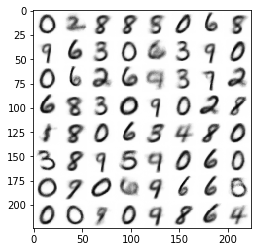

Train: Epoch: 371 | BCE: 0.17275 | KL Divergence: 3.44402
Val: Epoch: 371 | BCE: 0.18453 | KL Divergence: 3.43832
Train: Epoch: 372 | BCE: 0.17509 | KL Divergence: 3.42690
Val: Epoch: 372 | BCE: 0.18030 | KL Divergence: 3.44488
Train: Epoch: 373 | BCE: 0.17660 | KL Divergence: 3.41848
Val: Epoch: 373 | BCE: 0.18405 | KL Divergence: 3.43952
Train: Epoch: 374 | BCE: 0.17373 | KL Divergence: 3.44250
Val: Epoch: 374 | BCE: 0.18247 | KL Divergence: 3.45604
Train: Epoch: 375 | BCE: 0.17437 | KL Divergence: 3.43661
Val: Epoch: 375 | BCE: 0.18187 | KL Divergence: 3.45158
Train: Epoch: 376 | BCE: 0.17248 | KL Divergence: 3.46213
Val: Epoch: 376 | BCE: 0.18353 | KL Divergence: 3.41847
Train: Epoch: 377 | BCE: 0.17415 | KL Divergence: 3.42413
Val: Epoch: 377 | BCE: 0.18569 | KL Divergence: 3.43419
Train: Epoch: 378 | BCE: 0.17296 | KL Divergence: 3.44491
Val: Epoch: 378 | BCE: 0.18567 | KL Divergence: 3.48507
Train: Epoch: 379 | BCE: 0.17362 | KL Divergence: 3.44102
Val: Epoch: 379 | BCE: 0.18310

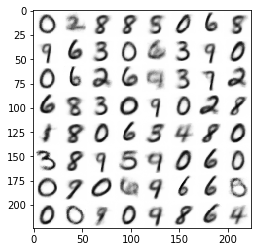

Train: Epoch: 381 | BCE: 0.17470 | KL Divergence: 3.43106
Val: Epoch: 381 | BCE: 0.18404 | KL Divergence: 3.44513
Train: Epoch: 382 | BCE: 0.17517 | KL Divergence: 3.43986
Val: Epoch: 382 | BCE: 0.18215 | KL Divergence: 3.47885
Train: Epoch: 383 | BCE: 0.17483 | KL Divergence: 3.43585
Val: Epoch: 383 | BCE: 0.18228 | KL Divergence: 3.41633
Train: Epoch: 384 | BCE: 0.17516 | KL Divergence: 3.44705
Val: Epoch: 384 | BCE: 0.18498 | KL Divergence: 3.43517
Train: Epoch: 385 | BCE: 0.17422 | KL Divergence: 3.44612
Val: Epoch: 385 | BCE: 0.18446 | KL Divergence: 3.43558
Train: Epoch: 386 | BCE: 0.17594 | KL Divergence: 3.45737
Val: Epoch: 386 | BCE: 0.18344 | KL Divergence: 3.42790
Train: Epoch: 387 | BCE: 0.17435 | KL Divergence: 3.43879
Val: Epoch: 387 | BCE: 0.18554 | KL Divergence: 3.41464
Train: Epoch: 388 | BCE: 0.17571 | KL Divergence: 3.45154
Val: Epoch: 388 | BCE: 0.18023 | KL Divergence: 3.49669
Train: Epoch: 389 | BCE: 0.17258 | KL Divergence: 3.44209
Val: Epoch: 389 | BCE: 0.17968

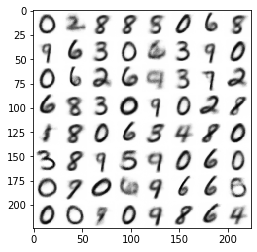

Train: Epoch: 391 | BCE: 0.17439 | KL Divergence: 3.45645
Val: Epoch: 391 | BCE: 0.18400 | KL Divergence: 3.46491
Train: Epoch: 392 | BCE: 0.17467 | KL Divergence: 3.44684
Val: Epoch: 392 | BCE: 0.18430 | KL Divergence: 3.46870
Train: Epoch: 393 | BCE: 0.17434 | KL Divergence: 3.45265
Val: Epoch: 393 | BCE: 0.18543 | KL Divergence: 3.45246
Train: Epoch: 394 | BCE: 0.17494 | KL Divergence: 3.45949
Val: Epoch: 394 | BCE: 0.18301 | KL Divergence: 3.48577
Train: Epoch: 395 | BCE: 0.17516 | KL Divergence: 3.46780
Val: Epoch: 395 | BCE: 0.18374 | KL Divergence: 3.47486
Train: Epoch: 396 | BCE: 0.17519 | KL Divergence: 3.46071
Val: Epoch: 396 | BCE: 0.18357 | KL Divergence: 3.45887
Train: Epoch: 397 | BCE: 0.17213 | KL Divergence: 3.46445
Val: Epoch: 397 | BCE: 0.18232 | KL Divergence: 3.49369
Train: Epoch: 398 | BCE: 0.17292 | KL Divergence: 3.46680
Val: Epoch: 398 | BCE: 0.18227 | KL Divergence: 3.43849
Train: Epoch: 399 | BCE: 0.17364 | KL Divergence: 3.45982
Val: Epoch: 399 | BCE: 0.18009

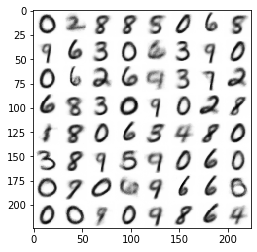

Train: Epoch: 401 | BCE: 0.17416 | KL Divergence: 3.44201
Val: Epoch: 401 | BCE: 0.18335 | KL Divergence: 3.44887
Train: Epoch: 402 | BCE: 0.17651 | KL Divergence: 3.46155
Val: Epoch: 402 | BCE: 0.18248 | KL Divergence: 3.47657
Train: Epoch: 403 | BCE: 0.17394 | KL Divergence: 3.45007
Val: Epoch: 403 | BCE: 0.18323 | KL Divergence: 3.49630
Train: Epoch: 404 | BCE: 0.17514 | KL Divergence: 3.45266
Val: Epoch: 404 | BCE: 0.18544 | KL Divergence: 3.48253
Train: Epoch: 405 | BCE: 0.17532 | KL Divergence: 3.45457
Val: Epoch: 405 | BCE: 0.18427 | KL Divergence: 3.44816
Train: Epoch: 406 | BCE: 0.17531 | KL Divergence: 3.44808
Val: Epoch: 406 | BCE: 0.18379 | KL Divergence: 3.46805
Train: Epoch: 407 | BCE: 0.17602 | KL Divergence: 3.47783
Val: Epoch: 407 | BCE: 0.18187 | KL Divergence: 3.49315
Train: Epoch: 408 | BCE: 0.17221 | KL Divergence: 3.46079
Val: Epoch: 408 | BCE: 0.18195 | KL Divergence: 3.49710
Train: Epoch: 409 | BCE: 0.17442 | KL Divergence: 3.45316
Val: Epoch: 409 | BCE: 0.18498

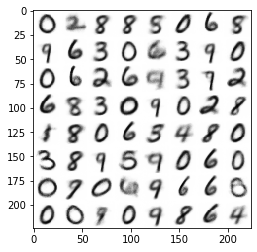

Train: Epoch: 411 | BCE: 0.17174 | KL Divergence: 3.46304
Val: Epoch: 411 | BCE: 0.18299 | KL Divergence: 3.46602
Train: Epoch: 412 | BCE: 0.17186 | KL Divergence: 3.46683
Val: Epoch: 412 | BCE: 0.18318 | KL Divergence: 3.48132
Train: Epoch: 413 | BCE: 0.17380 | KL Divergence: 3.46864
Val: Epoch: 413 | BCE: 0.18638 | KL Divergence: 3.46442
Train: Epoch: 414 | BCE: 0.17431 | KL Divergence: 3.46573
Val: Epoch: 414 | BCE: 0.18575 | KL Divergence: 3.49574
Train: Epoch: 415 | BCE: 0.17462 | KL Divergence: 3.45457
Val: Epoch: 415 | BCE: 0.18213 | KL Divergence: 3.49036
Train: Epoch: 416 | BCE: 0.17368 | KL Divergence: 3.48451
Val: Epoch: 416 | BCE: 0.18213 | KL Divergence: 3.46623
Train: Epoch: 417 | BCE: 0.17421 | KL Divergence: 3.46723
Val: Epoch: 417 | BCE: 0.18240 | KL Divergence: 3.43991
Train: Epoch: 418 | BCE: 0.17542 | KL Divergence: 3.47938
Val: Epoch: 418 | BCE: 0.18378 | KL Divergence: 3.52046
Train: Epoch: 419 | BCE: 0.17433 | KL Divergence: 3.45765
Val: Epoch: 419 | BCE: 0.18379

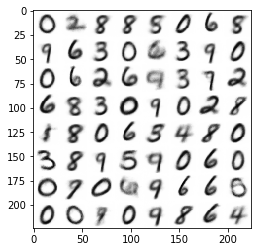

Train: Epoch: 421 | BCE: 0.17476 | KL Divergence: 3.48434
Val: Epoch: 421 | BCE: 0.18264 | KL Divergence: 3.50720
Train: Epoch: 422 | BCE: 0.17192 | KL Divergence: 3.49992
Val: Epoch: 422 | BCE: 0.18209 | KL Divergence: 3.50430
Train: Epoch: 423 | BCE: 0.17237 | KL Divergence: 3.48517
Val: Epoch: 423 | BCE: 0.18198 | KL Divergence: 3.53278
Train: Epoch: 424 | BCE: 0.17011 | KL Divergence: 3.50057
Val: Epoch: 424 | BCE: 0.18484 | KL Divergence: 3.49155
Train: Epoch: 425 | BCE: 0.17517 | KL Divergence: 3.46216
Val: Epoch: 425 | BCE: 0.18314 | KL Divergence: 3.48199
Train: Epoch: 426 | BCE: 0.17292 | KL Divergence: 3.48690
Val: Epoch: 426 | BCE: 0.18490 | KL Divergence: 3.50723
Train: Epoch: 427 | BCE: 0.17222 | KL Divergence: 3.48893
Val: Epoch: 427 | BCE: 0.18214 | KL Divergence: 3.50089
Train: Epoch: 428 | BCE: 0.17445 | KL Divergence: 3.49184
Val: Epoch: 428 | BCE: 0.18604 | KL Divergence: 3.50111
Train: Epoch: 429 | BCE: 0.17426 | KL Divergence: 3.47931
Val: Epoch: 429 | BCE: 0.18192

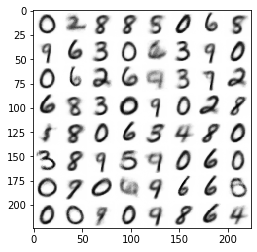

Train: Epoch: 431 | BCE: 0.17209 | KL Divergence: 3.48749
Val: Epoch: 431 | BCE: 0.18328 | KL Divergence: 3.50798
Train: Epoch: 432 | BCE: 0.17263 | KL Divergence: 3.48869
Val: Epoch: 432 | BCE: 0.18368 | KL Divergence: 3.49518
Train: Epoch: 433 | BCE: 0.17317 | KL Divergence: 3.47274
Val: Epoch: 433 | BCE: 0.18127 | KL Divergence: 3.49241
Train: Epoch: 434 | BCE: 0.17165 | KL Divergence: 3.48880
Val: Epoch: 434 | BCE: 0.18282 | KL Divergence: 3.49950
Train: Epoch: 435 | BCE: 0.17263 | KL Divergence: 3.50451
Val: Epoch: 435 | BCE: 0.18352 | KL Divergence: 3.52367
Train: Epoch: 436 | BCE: 0.17057 | KL Divergence: 3.51604
Val: Epoch: 436 | BCE: 0.18214 | KL Divergence: 3.50693
Train: Epoch: 437 | BCE: 0.17025 | KL Divergence: 3.48197
Val: Epoch: 437 | BCE: 0.18508 | KL Divergence: 3.49378
Train: Epoch: 438 | BCE: 0.17379 | KL Divergence: 3.49529
Val: Epoch: 438 | BCE: 0.18040 | KL Divergence: 3.53330
Train: Epoch: 439 | BCE: 0.17239 | KL Divergence: 3.49056
Val: Epoch: 439 | BCE: 0.18316

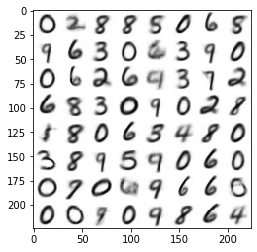

Train: Epoch: 441 | BCE: 0.17075 | KL Divergence: 3.48679
Val: Epoch: 441 | BCE: 0.18099 | KL Divergence: 3.51546
Train: Epoch: 442 | BCE: 0.17306 | KL Divergence: 3.49720
Val: Epoch: 442 | BCE: 0.18321 | KL Divergence: 3.48480
Train: Epoch: 443 | BCE: 0.17148 | KL Divergence: 3.48494
Val: Epoch: 443 | BCE: 0.18157 | KL Divergence: 3.50880
Train: Epoch: 444 | BCE: 0.17389 | KL Divergence: 3.48424
Val: Epoch: 444 | BCE: 0.18521 | KL Divergence: 3.47461
Train: Epoch: 445 | BCE: 0.17373 | KL Divergence: 3.47881
Val: Epoch: 445 | BCE: 0.18378 | KL Divergence: 3.47470
Train: Epoch: 446 | BCE: 0.17448 | KL Divergence: 3.48655
Val: Epoch: 446 | BCE: 0.18351 | KL Divergence: 3.51052
Train: Epoch: 447 | BCE: 0.17460 | KL Divergence: 3.49373
Val: Epoch: 447 | BCE: 0.18504 | KL Divergence: 3.49574
Train: Epoch: 448 | BCE: 0.17528 | KL Divergence: 3.48059
Val: Epoch: 448 | BCE: 0.18190 | KL Divergence: 3.50827
Train: Epoch: 449 | BCE: 0.17358 | KL Divergence: 3.47784
Val: Epoch: 449 | BCE: 0.18057

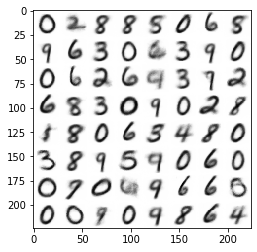

Train: Epoch: 451 | BCE: 0.17132 | KL Divergence: 3.50635
Val: Epoch: 451 | BCE: 0.18345 | KL Divergence: 3.51966
Train: Epoch: 452 | BCE: 0.17236 | KL Divergence: 3.49664
Val: Epoch: 452 | BCE: 0.18529 | KL Divergence: 3.48681
Train: Epoch: 453 | BCE: 0.17225 | KL Divergence: 3.49286
Val: Epoch: 453 | BCE: 0.18172 | KL Divergence: 3.53147
Train: Epoch: 454 | BCE: 0.17371 | KL Divergence: 3.48177
Val: Epoch: 454 | BCE: 0.18352 | KL Divergence: 3.50777
Train: Epoch: 455 | BCE: 0.17171 | KL Divergence: 3.50956
Val: Epoch: 455 | BCE: 0.18537 | KL Divergence: 3.51755
Train: Epoch: 456 | BCE: 0.17378 | KL Divergence: 3.52543
Val: Epoch: 456 | BCE: 0.18168 | KL Divergence: 3.55231
Train: Epoch: 457 | BCE: 0.17285 | KL Divergence: 3.50949
Val: Epoch: 457 | BCE: 0.18269 | KL Divergence: 3.51404
Train: Epoch: 458 | BCE: 0.17166 | KL Divergence: 3.49951
Val: Epoch: 458 | BCE: 0.18408 | KL Divergence: 3.48796
Train: Epoch: 459 | BCE: 0.17226 | KL Divergence: 3.50840
Val: Epoch: 459 | BCE: 0.18070

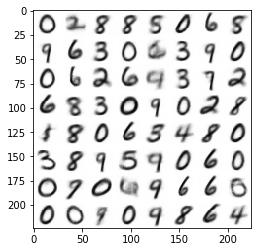

Train: Epoch: 461 | BCE: 0.17165 | KL Divergence: 3.49311
Val: Epoch: 461 | BCE: 0.18281 | KL Divergence: 3.52156
Train: Epoch: 462 | BCE: 0.17032 | KL Divergence: 3.52762
Val: Epoch: 462 | BCE: 0.18222 | KL Divergence: 3.51128
Train: Epoch: 463 | BCE: 0.17146 | KL Divergence: 3.50551
Val: Epoch: 463 | BCE: 0.18446 | KL Divergence: 3.53235
Train: Epoch: 464 | BCE: 0.17136 | KL Divergence: 3.49176
Val: Epoch: 464 | BCE: 0.18206 | KL Divergence: 3.47692
Train: Epoch: 465 | BCE: 0.17019 | KL Divergence: 3.52857
Val: Epoch: 465 | BCE: 0.18405 | KL Divergence: 3.54640
Train: Epoch: 466 | BCE: 0.17252 | KL Divergence: 3.51769
Val: Epoch: 466 | BCE: 0.18228 | KL Divergence: 3.53834
Train: Epoch: 467 | BCE: 0.17155 | KL Divergence: 3.52231
Val: Epoch: 467 | BCE: 0.18399 | KL Divergence: 3.51087
Train: Epoch: 468 | BCE: 0.17116 | KL Divergence: 3.49192
Val: Epoch: 468 | BCE: 0.18464 | KL Divergence: 3.53319
Train: Epoch: 469 | BCE: 0.17258 | KL Divergence: 3.49344
Val: Epoch: 469 | BCE: 0.18148

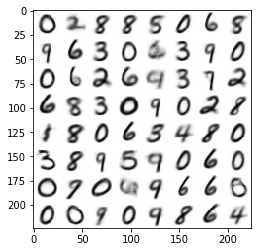

Train: Epoch: 471 | BCE: 0.17219 | KL Divergence: 3.50980
Val: Epoch: 471 | BCE: 0.18080 | KL Divergence: 3.52419
Train: Epoch: 472 | BCE: 0.17097 | KL Divergence: 3.50060
Val: Epoch: 472 | BCE: 0.18239 | KL Divergence: 3.49587
Train: Epoch: 473 | BCE: 0.16923 | KL Divergence: 3.51897
Val: Epoch: 473 | BCE: 0.18176 | KL Divergence: 3.50269
Train: Epoch: 474 | BCE: 0.17106 | KL Divergence: 3.51352
Val: Epoch: 474 | BCE: 0.18172 | KL Divergence: 3.50844
Train: Epoch: 475 | BCE: 0.17318 | KL Divergence: 3.52911
Val: Epoch: 475 | BCE: 0.18120 | KL Divergence: 3.52803
Train: Epoch: 476 | BCE: 0.17216 | KL Divergence: 3.50984
Val: Epoch: 476 | BCE: 0.18334 | KL Divergence: 3.49739
Train: Epoch: 477 | BCE: 0.17228 | KL Divergence: 3.52096
Val: Epoch: 477 | BCE: 0.18122 | KL Divergence: 3.49730
Train: Epoch: 478 | BCE: 0.17015 | KL Divergence: 3.52310
Val: Epoch: 478 | BCE: 0.18183 | KL Divergence: 3.53579
Train: Epoch: 479 | BCE: 0.17082 | KL Divergence: 3.52500
Val: Epoch: 479 | BCE: 0.18351

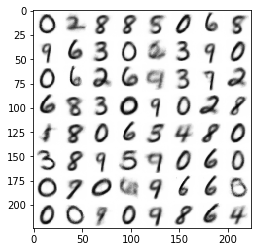

Train: Epoch: 481 | BCE: 0.16984 | KL Divergence: 3.51016
Val: Epoch: 481 | BCE: 0.18024 | KL Divergence: 3.53933
Train: Epoch: 482 | BCE: 0.17090 | KL Divergence: 3.52588
Val: Epoch: 482 | BCE: 0.18439 | KL Divergence: 3.51835
Train: Epoch: 483 | BCE: 0.17176 | KL Divergence: 3.52871
Val: Epoch: 483 | BCE: 0.18265 | KL Divergence: 3.53390
Train: Epoch: 484 | BCE: 0.17265 | KL Divergence: 3.51080
Val: Epoch: 484 | BCE: 0.18048 | KL Divergence: 3.52588
Train: Epoch: 485 | BCE: 0.17176 | KL Divergence: 3.52957
Val: Epoch: 485 | BCE: 0.18376 | KL Divergence: 3.55580
Train: Epoch: 486 | BCE: 0.17193 | KL Divergence: 3.52129
Val: Epoch: 486 | BCE: 0.18039 | KL Divergence: 3.51085
Train: Epoch: 487 | BCE: 0.17094 | KL Divergence: 3.54759
Val: Epoch: 487 | BCE: 0.18380 | KL Divergence: 3.54736
Train: Epoch: 488 | BCE: 0.17273 | KL Divergence: 3.52849
Val: Epoch: 488 | BCE: 0.18349 | KL Divergence: 3.54618
Train: Epoch: 489 | BCE: 0.17092 | KL Divergence: 3.53502
Val: Epoch: 489 | BCE: 0.18447

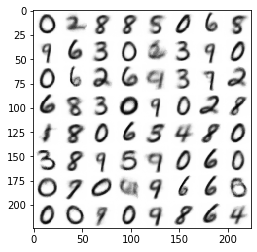

Train: Epoch: 491 | BCE: 0.17187 | KL Divergence: 3.53483
Val: Epoch: 491 | BCE: 0.18075 | KL Divergence: 3.53378
Train: Epoch: 492 | BCE: 0.17015 | KL Divergence: 3.55277
Val: Epoch: 492 | BCE: 0.18092 | KL Divergence: 3.56259
Train: Epoch: 493 | BCE: 0.17317 | KL Divergence: 3.53103
Val: Epoch: 493 | BCE: 0.18113 | KL Divergence: 3.52783
Train: Epoch: 494 | BCE: 0.17210 | KL Divergence: 3.52639
Val: Epoch: 494 | BCE: 0.17926 | KL Divergence: 3.52240
Train: Epoch: 495 | BCE: 0.17198 | KL Divergence: 3.52874
Val: Epoch: 495 | BCE: 0.18470 | KL Divergence: 3.52934
Train: Epoch: 496 | BCE: 0.17121 | KL Divergence: 3.51734
Val: Epoch: 496 | BCE: 0.18024 | KL Divergence: 3.56260
Train: Epoch: 497 | BCE: 0.17199 | KL Divergence: 3.55318
Val: Epoch: 497 | BCE: 0.18260 | KL Divergence: 3.57549
Train: Epoch: 498 | BCE: 0.17091 | KL Divergence: 3.53364
Val: Epoch: 498 | BCE: 0.18393 | KL Divergence: 3.53132
Train: Epoch: 499 | BCE: 0.16974 | KL Divergence: 3.54247
Val: Epoch: 499 | BCE: 0.18084

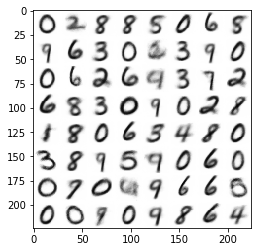

Train: Epoch: 501 | BCE: 0.16787 | KL Divergence: 3.53913
Val: Epoch: 501 | BCE: 0.18077 | KL Divergence: 3.55012
Train: Epoch: 502 | BCE: 0.17181 | KL Divergence: 3.52064
Val: Epoch: 502 | BCE: 0.18189 | KL Divergence: 3.53347
Train: Epoch: 503 | BCE: 0.17297 | KL Divergence: 3.54262
Val: Epoch: 503 | BCE: 0.18248 | KL Divergence: 3.57461
Train: Epoch: 504 | BCE: 0.17225 | KL Divergence: 3.52518
Val: Epoch: 504 | BCE: 0.18384 | KL Divergence: 3.55914
Train: Epoch: 505 | BCE: 0.17218 | KL Divergence: 3.54407
Val: Epoch: 505 | BCE: 0.18476 | KL Divergence: 3.56452
Train: Epoch: 506 | BCE: 0.17076 | KL Divergence: 3.56182
Val: Epoch: 506 | BCE: 0.18378 | KL Divergence: 3.54052
Train: Epoch: 507 | BCE: 0.17093 | KL Divergence: 3.53093
Val: Epoch: 507 | BCE: 0.18040 | KL Divergence: 3.57029
Train: Epoch: 508 | BCE: 0.17003 | KL Divergence: 3.55359
Val: Epoch: 508 | BCE: 0.18019 | KL Divergence: 3.58339
Train: Epoch: 509 | BCE: 0.17141 | KL Divergence: 3.55472
Val: Epoch: 509 | BCE: 0.18323

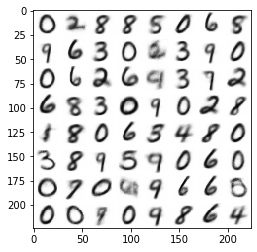

Train: Epoch: 511 | BCE: 0.17189 | KL Divergence: 3.55551
Val: Epoch: 511 | BCE: 0.18081 | KL Divergence: 3.55647
Train: Epoch: 512 | BCE: 0.16986 | KL Divergence: 3.54510
Val: Epoch: 512 | BCE: 0.18451 | KL Divergence: 3.53463
Train: Epoch: 513 | BCE: 0.17059 | KL Divergence: 3.53622
Val: Epoch: 513 | BCE: 0.18341 | KL Divergence: 3.56282
Train: Epoch: 514 | BCE: 0.17069 | KL Divergence: 3.55686
Val: Epoch: 514 | BCE: 0.18402 | KL Divergence: 3.57025
Train: Epoch: 515 | BCE: 0.16987 | KL Divergence: 3.55375
Val: Epoch: 515 | BCE: 0.18053 | KL Divergence: 3.56625
Train: Epoch: 516 | BCE: 0.17019 | KL Divergence: 3.54626
Val: Epoch: 516 | BCE: 0.18258 | KL Divergence: 3.54984
Train: Epoch: 517 | BCE: 0.17044 | KL Divergence: 3.54557
Val: Epoch: 517 | BCE: 0.18168 | KL Divergence: 3.51486
Train: Epoch: 518 | BCE: 0.17129 | KL Divergence: 3.55698
Val: Epoch: 518 | BCE: 0.18227 | KL Divergence: 3.53809
Train: Epoch: 519 | BCE: 0.16850 | KL Divergence: 3.55936
Val: Epoch: 519 | BCE: 0.18265

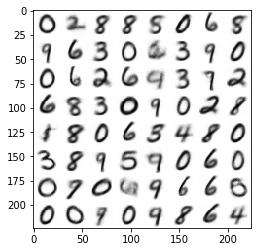

Train: Epoch: 521 | BCE: 0.17053 | KL Divergence: 3.55933
Val: Epoch: 521 | BCE: 0.18329 | KL Divergence: 3.55934
Train: Epoch: 522 | BCE: 0.17175 | KL Divergence: 3.53649
Val: Epoch: 522 | BCE: 0.18157 | KL Divergence: 3.60013
Train: Epoch: 523 | BCE: 0.17348 | KL Divergence: 3.52659
Val: Epoch: 523 | BCE: 0.18266 | KL Divergence: 3.56037
Train: Epoch: 524 | BCE: 0.16855 | KL Divergence: 3.56862
Val: Epoch: 524 | BCE: 0.18102 | KL Divergence: 3.58500
Train: Epoch: 525 | BCE: 0.16940 | KL Divergence: 3.55963
Val: Epoch: 525 | BCE: 0.18219 | KL Divergence: 3.54828
Train: Epoch: 526 | BCE: 0.17121 | KL Divergence: 3.56410
Val: Epoch: 526 | BCE: 0.18436 | KL Divergence: 3.54146
Train: Epoch: 527 | BCE: 0.16742 | KL Divergence: 3.55970
Val: Epoch: 527 | BCE: 0.18258 | KL Divergence: 3.57240
Train: Epoch: 528 | BCE: 0.16990 | KL Divergence: 3.54909
Val: Epoch: 528 | BCE: 0.17934 | KL Divergence: 3.58186
Train: Epoch: 529 | BCE: 0.17032 | KL Divergence: 3.56553
Val: Epoch: 529 | BCE: 0.18070

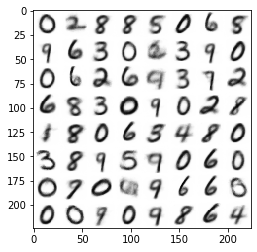

Train: Epoch: 531 | BCE: 0.17200 | KL Divergence: 3.54651
Val: Epoch: 531 | BCE: 0.18154 | KL Divergence: 3.55755
Train: Epoch: 532 | BCE: 0.16975 | KL Divergence: 3.55872
Val: Epoch: 532 | BCE: 0.18356 | KL Divergence: 3.57680
Train: Epoch: 533 | BCE: 0.17125 | KL Divergence: 3.55059
Val: Epoch: 533 | BCE: 0.18110 | KL Divergence: 3.61305
Train: Epoch: 534 | BCE: 0.17146 | KL Divergence: 3.55016
Val: Epoch: 534 | BCE: 0.18057 | KL Divergence: 3.55974
Train: Epoch: 535 | BCE: 0.17036 | KL Divergence: 3.55097
Val: Epoch: 535 | BCE: 0.18539 | KL Divergence: 3.56156
Train: Epoch: 536 | BCE: 0.17269 | KL Divergence: 3.55401
Val: Epoch: 536 | BCE: 0.18172 | KL Divergence: 3.57413
Train: Epoch: 537 | BCE: 0.17096 | KL Divergence: 3.55429
Val: Epoch: 537 | BCE: 0.18367 | KL Divergence: 3.56421
Train: Epoch: 538 | BCE: 0.17026 | KL Divergence: 3.56477
Val: Epoch: 538 | BCE: 0.18125 | KL Divergence: 3.57867
Train: Epoch: 539 | BCE: 0.16771 | KL Divergence: 3.56880
Val: Epoch: 539 | BCE: 0.18129

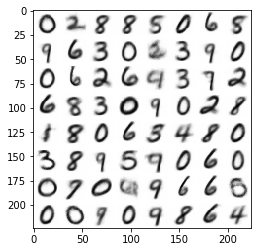

Train: Epoch: 541 | BCE: 0.16924 | KL Divergence: 3.56017
Val: Epoch: 541 | BCE: 0.18225 | KL Divergence: 3.56611
Train: Epoch: 542 | BCE: 0.16826 | KL Divergence: 3.57435
Val: Epoch: 542 | BCE: 0.18281 | KL Divergence: 3.56102
Train: Epoch: 543 | BCE: 0.16829 | KL Divergence: 3.55410
Val: Epoch: 543 | BCE: 0.18339 | KL Divergence: 3.57204
Train: Epoch: 544 | BCE: 0.16606 | KL Divergence: 3.56670
Val: Epoch: 544 | BCE: 0.18432 | KL Divergence: 3.55803
Train: Epoch: 545 | BCE: 0.16848 | KL Divergence: 3.56571
Val: Epoch: 545 | BCE: 0.18126 | KL Divergence: 3.57530
Train: Epoch: 546 | BCE: 0.16829 | KL Divergence: 3.56615
Val: Epoch: 546 | BCE: 0.18427 | KL Divergence: 3.56891
Train: Epoch: 547 | BCE: 0.17073 | KL Divergence: 3.55319
Val: Epoch: 547 | BCE: 0.18424 | KL Divergence: 3.58565
Train: Epoch: 548 | BCE: 0.17188 | KL Divergence: 3.57586
Val: Epoch: 548 | BCE: 0.18162 | KL Divergence: 3.55165
Train: Epoch: 549 | BCE: 0.17177 | KL Divergence: 3.54703
Val: Epoch: 549 | BCE: 0.18134

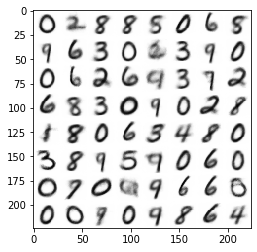

Train: Epoch: 551 | BCE: 0.16928 | KL Divergence: 3.54846
Val: Epoch: 551 | BCE: 0.18109 | KL Divergence: 3.55738
Train: Epoch: 552 | BCE: 0.16963 | KL Divergence: 3.55677
Val: Epoch: 552 | BCE: 0.18217 | KL Divergence: 3.59189
Train: Epoch: 553 | BCE: 0.17002 | KL Divergence: 3.58981
Val: Epoch: 553 | BCE: 0.18181 | KL Divergence: 3.57453
Train: Epoch: 554 | BCE: 0.16750 | KL Divergence: 3.57516
Val: Epoch: 554 | BCE: 0.18021 | KL Divergence: 3.58034
Train: Epoch: 555 | BCE: 0.16922 | KL Divergence: 3.57417
Val: Epoch: 555 | BCE: 0.18361 | KL Divergence: 3.60008
Train: Epoch: 556 | BCE: 0.16910 | KL Divergence: 3.56760
Val: Epoch: 556 | BCE: 0.18057 | KL Divergence: 3.55671
Train: Epoch: 557 | BCE: 0.16930 | KL Divergence: 3.57894
Val: Epoch: 557 | BCE: 0.18023 | KL Divergence: 3.57799
Train: Epoch: 558 | BCE: 0.16871 | KL Divergence: 3.56889
Val: Epoch: 558 | BCE: 0.18252 | KL Divergence: 3.56631
Train: Epoch: 559 | BCE: 0.16954 | KL Divergence: 3.54843
Val: Epoch: 559 | BCE: 0.18323

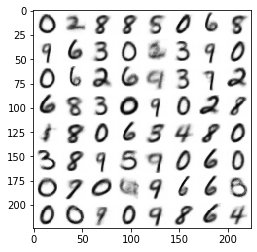

Train: Epoch: 561 | BCE: 0.16759 | KL Divergence: 3.58573
Val: Epoch: 561 | BCE: 0.18221 | KL Divergence: 3.57104
Train: Epoch: 562 | BCE: 0.17033 | KL Divergence: 3.58022
Val: Epoch: 562 | BCE: 0.18387 | KL Divergence: 3.58060
Train: Epoch: 563 | BCE: 0.16952 | KL Divergence: 3.56927
Val: Epoch: 563 | BCE: 0.18345 | KL Divergence: 3.57007
Train: Epoch: 564 | BCE: 0.17057 | KL Divergence: 3.57157
Val: Epoch: 564 | BCE: 0.18203 | KL Divergence: 3.57802
Train: Epoch: 565 | BCE: 0.16761 | KL Divergence: 3.57735
Val: Epoch: 565 | BCE: 0.18239 | KL Divergence: 3.61520
Train: Epoch: 566 | BCE: 0.16944 | KL Divergence: 3.57297
Val: Epoch: 566 | BCE: 0.18104 | KL Divergence: 3.57185
Train: Epoch: 567 | BCE: 0.16923 | KL Divergence: 3.56562
Val: Epoch: 567 | BCE: 0.18367 | KL Divergence: 3.58865
Train: Epoch: 568 | BCE: 0.16841 | KL Divergence: 3.59504
Val: Epoch: 568 | BCE: 0.17921 | KL Divergence: 3.54656
Train: Epoch: 569 | BCE: 0.16878 | KL Divergence: 3.58029
Val: Epoch: 569 | BCE: 0.18134

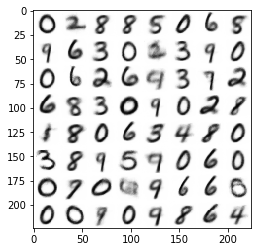

Train: Epoch: 571 | BCE: 0.16901 | KL Divergence: 3.58611
Val: Epoch: 571 | BCE: 0.18266 | KL Divergence: 3.63010
Train: Epoch: 572 | BCE: 0.17016 | KL Divergence: 3.57310
Val: Epoch: 572 | BCE: 0.18173 | KL Divergence: 3.57832
Train: Epoch: 573 | BCE: 0.16744 | KL Divergence: 3.59222
Val: Epoch: 573 | BCE: 0.18553 | KL Divergence: 3.60369
Train: Epoch: 574 | BCE: 0.16867 | KL Divergence: 3.58310
Val: Epoch: 574 | BCE: 0.18480 | KL Divergence: 3.58552
Train: Epoch: 575 | BCE: 0.16936 | KL Divergence: 3.59003
Val: Epoch: 575 | BCE: 0.18007 | KL Divergence: 3.60035
Train: Epoch: 576 | BCE: 0.16650 | KL Divergence: 3.60906
Val: Epoch: 576 | BCE: 0.18481 | KL Divergence: 3.58765
Train: Epoch: 577 | BCE: 0.16721 | KL Divergence: 3.60044
Val: Epoch: 577 | BCE: 0.18470 | KL Divergence: 3.58780
Train: Epoch: 578 | BCE: 0.17064 | KL Divergence: 3.58034
Val: Epoch: 578 | BCE: 0.18254 | KL Divergence: 3.59319
Train: Epoch: 579 | BCE: 0.16957 | KL Divergence: 3.56506
Val: Epoch: 579 | BCE: 0.18450

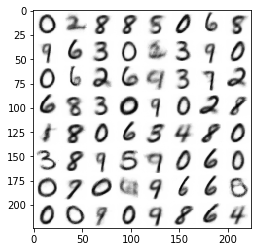

Train: Epoch: 581 | BCE: 0.16730 | KL Divergence: 3.59542
Val: Epoch: 581 | BCE: 0.18276 | KL Divergence: 3.59208
Train: Epoch: 582 | BCE: 0.17010 | KL Divergence: 3.57716
Val: Epoch: 582 | BCE: 0.18135 | KL Divergence: 3.56770
Train: Epoch: 583 | BCE: 0.16909 | KL Divergence: 3.58491
Val: Epoch: 583 | BCE: 0.18398 | KL Divergence: 3.61795
Train: Epoch: 584 | BCE: 0.16751 | KL Divergence: 3.60985
Val: Epoch: 584 | BCE: 0.18369 | KL Divergence: 3.61491
Train: Epoch: 585 | BCE: 0.17085 | KL Divergence: 3.58668
Val: Epoch: 585 | BCE: 0.17956 | KL Divergence: 3.59549
Train: Epoch: 586 | BCE: 0.16969 | KL Divergence: 3.58646
Val: Epoch: 586 | BCE: 0.18295 | KL Divergence: 3.57017
Train: Epoch: 587 | BCE: 0.16958 | KL Divergence: 3.58287
Val: Epoch: 587 | BCE: 0.18125 | KL Divergence: 3.60274
Train: Epoch: 588 | BCE: 0.16799 | KL Divergence: 3.59014
Val: Epoch: 588 | BCE: 0.18198 | KL Divergence: 3.60193
Train: Epoch: 589 | BCE: 0.16909 | KL Divergence: 3.59997
Val: Epoch: 589 | BCE: 0.18252

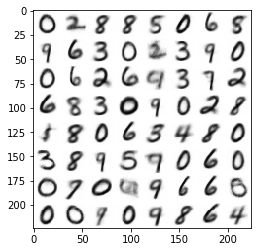

Train: Epoch: 591 | BCE: 0.16868 | KL Divergence: 3.60491
Val: Epoch: 591 | BCE: 0.18636 | KL Divergence: 3.59667
Train: Epoch: 592 | BCE: 0.16858 | KL Divergence: 3.59159
Val: Epoch: 592 | BCE: 0.18088 | KL Divergence: 3.59348
Train: Epoch: 593 | BCE: 0.16863 | KL Divergence: 3.60746
Val: Epoch: 593 | BCE: 0.18115 | KL Divergence: 3.59437
Train: Epoch: 594 | BCE: 0.16808 | KL Divergence: 3.59879
Val: Epoch: 594 | BCE: 0.18273 | KL Divergence: 3.59730
Train: Epoch: 595 | BCE: 0.16923 | KL Divergence: 3.60415
Val: Epoch: 595 | BCE: 0.18140 | KL Divergence: 3.58912
Train: Epoch: 596 | BCE: 0.16891 | KL Divergence: 3.59229
Val: Epoch: 596 | BCE: 0.18188 | KL Divergence: 3.63140
Train: Epoch: 597 | BCE: 0.16686 | KL Divergence: 3.61211
Val: Epoch: 597 | BCE: 0.18467 | KL Divergence: 3.61082
Train: Epoch: 598 | BCE: 0.16776 | KL Divergence: 3.60071
Val: Epoch: 598 | BCE: 0.18062 | KL Divergence: 3.58589
Train: Epoch: 599 | BCE: 0.16828 | KL Divergence: 3.59872
Val: Epoch: 599 | BCE: 0.18034

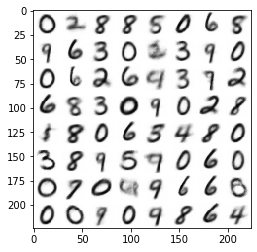

Train: Epoch: 601 | BCE: 0.16971 | KL Divergence: 3.58959
Val: Epoch: 601 | BCE: 0.18184 | KL Divergence: 3.60718
Train: Epoch: 602 | BCE: 0.16787 | KL Divergence: 3.60528
Val: Epoch: 602 | BCE: 0.18311 | KL Divergence: 3.60546
Train: Epoch: 603 | BCE: 0.16822 | KL Divergence: 3.59106
Val: Epoch: 603 | BCE: 0.18217 | KL Divergence: 3.58482
Train: Epoch: 604 | BCE: 0.16793 | KL Divergence: 3.61516
Val: Epoch: 604 | BCE: 0.18364 | KL Divergence: 3.62509
Train: Epoch: 605 | BCE: 0.16717 | KL Divergence: 3.58978
Val: Epoch: 605 | BCE: 0.18248 | KL Divergence: 3.58096
Train: Epoch: 606 | BCE: 0.16760 | KL Divergence: 3.61296
Val: Epoch: 606 | BCE: 0.18310 | KL Divergence: 3.63668
Train: Epoch: 607 | BCE: 0.17004 | KL Divergence: 3.58453
Val: Epoch: 607 | BCE: 0.17996 | KL Divergence: 3.58540
Train: Epoch: 608 | BCE: 0.16618 | KL Divergence: 3.60541
Val: Epoch: 608 | BCE: 0.18040 | KL Divergence: 3.61877
Train: Epoch: 609 | BCE: 0.16984 | KL Divergence: 3.58925
Val: Epoch: 609 | BCE: 0.18026

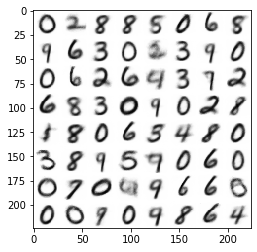

Train: Epoch: 611 | BCE: 0.16731 | KL Divergence: 3.61259
Val: Epoch: 611 | BCE: 0.17987 | KL Divergence: 3.63880
Train: Epoch: 612 | BCE: 0.16829 | KL Divergence: 3.60318
Val: Epoch: 612 | BCE: 0.18202 | KL Divergence: 3.61398
Train: Epoch: 613 | BCE: 0.16713 | KL Divergence: 3.60503
Val: Epoch: 613 | BCE: 0.18223 | KL Divergence: 3.62333
Train: Epoch: 614 | BCE: 0.17069 | KL Divergence: 3.58528
Val: Epoch: 614 | BCE: 0.17989 | KL Divergence: 3.63197
Train: Epoch: 615 | BCE: 0.16746 | KL Divergence: 3.61291
Val: Epoch: 615 | BCE: 0.18325 | KL Divergence: 3.60993
Train: Epoch: 616 | BCE: 0.16925 | KL Divergence: 3.60036
Val: Epoch: 616 | BCE: 0.18409 | KL Divergence: 3.60028
Train: Epoch: 617 | BCE: 0.16497 | KL Divergence: 3.61599
Val: Epoch: 617 | BCE: 0.18250 | KL Divergence: 3.59403
Train: Epoch: 618 | BCE: 0.16741 | KL Divergence: 3.59929
Val: Epoch: 618 | BCE: 0.17909 | KL Divergence: 3.61264
Train: Epoch: 619 | BCE: 0.16729 | KL Divergence: 3.62242
Val: Epoch: 619 | BCE: 0.18065

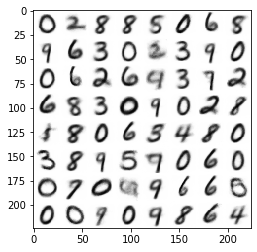

Train: Epoch: 621 | BCE: 0.16839 | KL Divergence: 3.60282
Val: Epoch: 621 | BCE: 0.18048 | KL Divergence: 3.62418
Train: Epoch: 622 | BCE: 0.16621 | KL Divergence: 3.61115
Val: Epoch: 622 | BCE: 0.18187 | KL Divergence: 3.61790
Train: Epoch: 623 | BCE: 0.16998 | KL Divergence: 3.60330
Val: Epoch: 623 | BCE: 0.18109 | KL Divergence: 3.63019
Train: Epoch: 624 | BCE: 0.16746 | KL Divergence: 3.61834
Val: Epoch: 624 | BCE: 0.18210 | KL Divergence: 3.60038
Train: Epoch: 625 | BCE: 0.16859 | KL Divergence: 3.60501
Val: Epoch: 625 | BCE: 0.18149 | KL Divergence: 3.63642
Train: Epoch: 626 | BCE: 0.16904 | KL Divergence: 3.61036
Val: Epoch: 626 | BCE: 0.18301 | KL Divergence: 3.64168
Train: Epoch: 627 | BCE: 0.16868 | KL Divergence: 3.60391
Val: Epoch: 627 | BCE: 0.18534 | KL Divergence: 3.62386
Train: Epoch: 628 | BCE: 0.16749 | KL Divergence: 3.62476
Val: Epoch: 628 | BCE: 0.18043 | KL Divergence: 3.64442
Train: Epoch: 629 | BCE: 0.16842 | KL Divergence: 3.63963
Val: Epoch: 629 | BCE: 0.18141

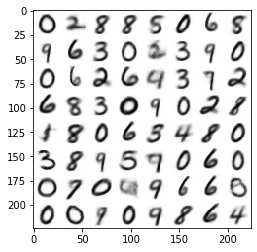

Train: Epoch: 631 | BCE: 0.16718 | KL Divergence: 3.61294
Val: Epoch: 631 | BCE: 0.18098 | KL Divergence: 3.59323
Train: Epoch: 632 | BCE: 0.16716 | KL Divergence: 3.60620
Val: Epoch: 632 | BCE: 0.18141 | KL Divergence: 3.64833
Train: Epoch: 633 | BCE: 0.16761 | KL Divergence: 3.63713
Val: Epoch: 633 | BCE: 0.18231 | KL Divergence: 3.63436
Train: Epoch: 634 | BCE: 0.16797 | KL Divergence: 3.62301
Val: Epoch: 634 | BCE: 0.18335 | KL Divergence: 3.65135
Train: Epoch: 635 | BCE: 0.16748 | KL Divergence: 3.63281
Val: Epoch: 635 | BCE: 0.18269 | KL Divergence: 3.66325
Train: Epoch: 636 | BCE: 0.16598 | KL Divergence: 3.61493
Val: Epoch: 636 | BCE: 0.17935 | KL Divergence: 3.61128
Train: Epoch: 637 | BCE: 0.16894 | KL Divergence: 3.62109
Val: Epoch: 637 | BCE: 0.18365 | KL Divergence: 3.59314
Train: Epoch: 638 | BCE: 0.16689 | KL Divergence: 3.61658
Val: Epoch: 638 | BCE: 0.18195 | KL Divergence: 3.60999
Train: Epoch: 639 | BCE: 0.16444 | KL Divergence: 3.61075
Val: Epoch: 639 | BCE: 0.18191

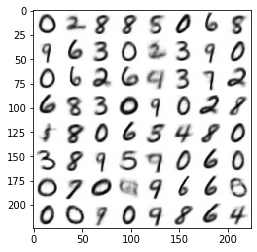

Train: Epoch: 641 | BCE: 0.16733 | KL Divergence: 3.62397
Val: Epoch: 641 | BCE: 0.18247 | KL Divergence: 3.59521
Train: Epoch: 642 | BCE: 0.16865 | KL Divergence: 3.64241
Val: Epoch: 642 | BCE: 0.18101 | KL Divergence: 3.67621
Train: Epoch: 643 | BCE: 0.16656 | KL Divergence: 3.62628
Val: Epoch: 643 | BCE: 0.18112 | KL Divergence: 3.62752
Train: Epoch: 644 | BCE: 0.16781 | KL Divergence: 3.61927
Val: Epoch: 644 | BCE: 0.18138 | KL Divergence: 3.60052
Train: Epoch: 645 | BCE: 0.16889 | KL Divergence: 3.62446
Val: Epoch: 645 | BCE: 0.18053 | KL Divergence: 3.63955
Train: Epoch: 646 | BCE: 0.16804 | KL Divergence: 3.62422
Val: Epoch: 646 | BCE: 0.18375 | KL Divergence: 3.62527
Train: Epoch: 647 | BCE: 0.16792 | KL Divergence: 3.63195
Val: Epoch: 647 | BCE: 0.18226 | KL Divergence: 3.63874
Train: Epoch: 648 | BCE: 0.16563 | KL Divergence: 3.64050
Val: Epoch: 648 | BCE: 0.18164 | KL Divergence: 3.63000
Train: Epoch: 649 | BCE: 0.16854 | KL Divergence: 3.63085
Val: Epoch: 649 | BCE: 0.18175

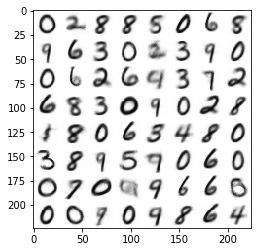

Train: Epoch: 651 | BCE: 0.16705 | KL Divergence: 3.63669
Val: Epoch: 651 | BCE: 0.18119 | KL Divergence: 3.64220
Train: Epoch: 652 | BCE: 0.16659 | KL Divergence: 3.62164
Val: Epoch: 652 | BCE: 0.18243 | KL Divergence: 3.60872
Train: Epoch: 653 | BCE: 0.16521 | KL Divergence: 3.63770
Val: Epoch: 653 | BCE: 0.18032 | KL Divergence: 3.65798
Train: Epoch: 654 | BCE: 0.16484 | KL Divergence: 3.64868
Val: Epoch: 654 | BCE: 0.18110 | KL Divergence: 3.63832
Train: Epoch: 655 | BCE: 0.16627 | KL Divergence: 3.63816
Val: Epoch: 655 | BCE: 0.18300 | KL Divergence: 3.64822
Train: Epoch: 656 | BCE: 0.16581 | KL Divergence: 3.62769
Val: Epoch: 656 | BCE: 0.18201 | KL Divergence: 3.61075
Train: Epoch: 657 | BCE: 0.16742 | KL Divergence: 3.62654
Val: Epoch: 657 | BCE: 0.18381 | KL Divergence: 3.62285
Train: Epoch: 658 | BCE: 0.16885 | KL Divergence: 3.62201
Val: Epoch: 658 | BCE: 0.18206 | KL Divergence: 3.61401
Train: Epoch: 659 | BCE: 0.16806 | KL Divergence: 3.63669
Val: Epoch: 659 | BCE: 0.18298

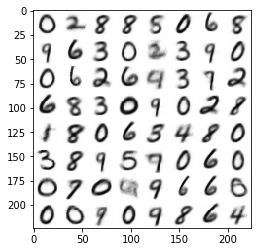

Train: Epoch: 661 | BCE: 0.16565 | KL Divergence: 3.61724
Val: Epoch: 661 | BCE: 0.18165 | KL Divergence: 3.63312
Train: Epoch: 662 | BCE: 0.16579 | KL Divergence: 3.62788
Val: Epoch: 662 | BCE: 0.18087 | KL Divergence: 3.63427
Train: Epoch: 663 | BCE: 0.16793 | KL Divergence: 3.62617
Val: Epoch: 663 | BCE: 0.18299 | KL Divergence: 3.65504
Train: Epoch: 664 | BCE: 0.16757 | KL Divergence: 3.63341
Val: Epoch: 664 | BCE: 0.18166 | KL Divergence: 3.66037
Train: Epoch: 665 | BCE: 0.16492 | KL Divergence: 3.64394
Val: Epoch: 665 | BCE: 0.18000 | KL Divergence: 3.65298
Train: Epoch: 666 | BCE: 0.16845 | KL Divergence: 3.62439
Val: Epoch: 666 | BCE: 0.18078 | KL Divergence: 3.62298
Train: Epoch: 667 | BCE: 0.16643 | KL Divergence: 3.63424
Val: Epoch: 667 | BCE: 0.18214 | KL Divergence: 3.64861
Train: Epoch: 668 | BCE: 0.16714 | KL Divergence: 3.63290
Val: Epoch: 668 | BCE: 0.18302 | KL Divergence: 3.65508
Train: Epoch: 669 | BCE: 0.16738 | KL Divergence: 3.64433
Val: Epoch: 669 | BCE: 0.18268

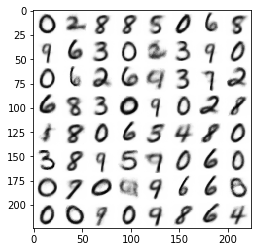

Train: Epoch: 671 | BCE: 0.16809 | KL Divergence: 3.63010
Val: Epoch: 671 | BCE: 0.18432 | KL Divergence: 3.64232
Train: Epoch: 672 | BCE: 0.16663 | KL Divergence: 3.63033
Val: Epoch: 672 | BCE: 0.18176 | KL Divergence: 3.64314
Train: Epoch: 673 | BCE: 0.16802 | KL Divergence: 3.64673
Val: Epoch: 673 | BCE: 0.18084 | KL Divergence: 3.64388
Train: Epoch: 674 | BCE: 0.16540 | KL Divergence: 3.62741
Val: Epoch: 674 | BCE: 0.17926 | KL Divergence: 3.63152
Train: Epoch: 675 | BCE: 0.16778 | KL Divergence: 3.64208
Val: Epoch: 675 | BCE: 0.18429 | KL Divergence: 3.69055
Train: Epoch: 676 | BCE: 0.16671 | KL Divergence: 3.65811
Val: Epoch: 676 | BCE: 0.18545 | KL Divergence: 3.63006
Train: Epoch: 677 | BCE: 0.16716 | KL Divergence: 3.65218
Val: Epoch: 677 | BCE: 0.18303 | KL Divergence: 3.63278
Train: Epoch: 678 | BCE: 0.16354 | KL Divergence: 3.63283
Val: Epoch: 678 | BCE: 0.18198 | KL Divergence: 3.65639
Train: Epoch: 679 | BCE: 0.16757 | KL Divergence: 3.63276
Val: Epoch: 679 | BCE: 0.18161

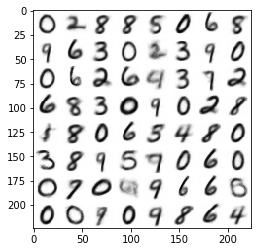

Train: Epoch: 681 | BCE: 0.16698 | KL Divergence: 3.63870
Val: Epoch: 681 | BCE: 0.18229 | KL Divergence: 3.64666
Train: Epoch: 682 | BCE: 0.16795 | KL Divergence: 3.64089
Val: Epoch: 682 | BCE: 0.18440 | KL Divergence: 3.62804
Train: Epoch: 683 | BCE: 0.16909 | KL Divergence: 3.62527
Val: Epoch: 683 | BCE: 0.18003 | KL Divergence: 3.64519
Train: Epoch: 684 | BCE: 0.16626 | KL Divergence: 3.65239
Val: Epoch: 684 | BCE: 0.18035 | KL Divergence: 3.67518
Train: Epoch: 685 | BCE: 0.16717 | KL Divergence: 3.63690
Val: Epoch: 685 | BCE: 0.18058 | KL Divergence: 3.62446
Train: Epoch: 686 | BCE: 0.16587 | KL Divergence: 3.64814
Val: Epoch: 686 | BCE: 0.18392 | KL Divergence: 3.64929
Train: Epoch: 687 | BCE: 0.16493 | KL Divergence: 3.65419
Val: Epoch: 687 | BCE: 0.18405 | KL Divergence: 3.68112
Train: Epoch: 688 | BCE: 0.16738 | KL Divergence: 3.65161
Val: Epoch: 688 | BCE: 0.18405 | KL Divergence: 3.63243
Train: Epoch: 689 | BCE: 0.16664 | KL Divergence: 3.65391
Val: Epoch: 689 | BCE: 0.18442

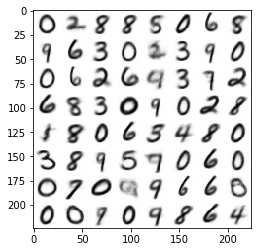

Train: Epoch: 691 | BCE: 0.16491 | KL Divergence: 3.66149
Val: Epoch: 691 | BCE: 0.18104 | KL Divergence: 3.62331
Train: Epoch: 692 | BCE: 0.16719 | KL Divergence: 3.63724
Val: Epoch: 692 | BCE: 0.18175 | KL Divergence: 3.63636
Train: Epoch: 693 | BCE: 0.16894 | KL Divergence: 3.62777
Val: Epoch: 693 | BCE: 0.18198 | KL Divergence: 3.67686
Train: Epoch: 694 | BCE: 0.16638 | KL Divergence: 3.64958
Val: Epoch: 694 | BCE: 0.18171 | KL Divergence: 3.64359
Train: Epoch: 695 | BCE: 0.16568 | KL Divergence: 3.66206
Val: Epoch: 695 | BCE: 0.18349 | KL Divergence: 3.65681
Train: Epoch: 696 | BCE: 0.16911 | KL Divergence: 3.64203
Val: Epoch: 696 | BCE: 0.18010 | KL Divergence: 3.63919
Train: Epoch: 697 | BCE: 0.16518 | KL Divergence: 3.65783
Val: Epoch: 697 | BCE: 0.18183 | KL Divergence: 3.65780
Train: Epoch: 698 | BCE: 0.16601 | KL Divergence: 3.64618
Val: Epoch: 698 | BCE: 0.18128 | KL Divergence: 3.65426
Train: Epoch: 699 | BCE: 0.16694 | KL Divergence: 3.65938
Val: Epoch: 699 | BCE: 0.18368

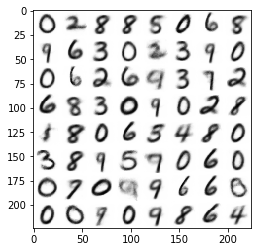

Train: Epoch: 701 | BCE: 0.16630 | KL Divergence: 3.63342
Val: Epoch: 701 | BCE: 0.18028 | KL Divergence: 3.66646
Train: Epoch: 702 | BCE: 0.16733 | KL Divergence: 3.64496
Val: Epoch: 702 | BCE: 0.18288 | KL Divergence: 3.68707
Train: Epoch: 703 | BCE: 0.16640 | KL Divergence: 3.65782
Val: Epoch: 703 | BCE: 0.18338 | KL Divergence: 3.68083
Train: Epoch: 704 | BCE: 0.16454 | KL Divergence: 3.66793
Val: Epoch: 704 | BCE: 0.18012 | KL Divergence: 3.70137
Train: Epoch: 705 | BCE: 0.16921 | KL Divergence: 3.66990
Val: Epoch: 705 | BCE: 0.17892 | KL Divergence: 3.69370
Train: Epoch: 706 | BCE: 0.16407 | KL Divergence: 3.65743
Val: Epoch: 706 | BCE: 0.18100 | KL Divergence: 3.65267
Train: Epoch: 707 | BCE: 0.16492 | KL Divergence: 3.65899
Val: Epoch: 707 | BCE: 0.18170 | KL Divergence: 3.66747
Train: Epoch: 708 | BCE: 0.16441 | KL Divergence: 3.66529
Val: Epoch: 708 | BCE: 0.18086 | KL Divergence: 3.66522
Train: Epoch: 709 | BCE: 0.16553 | KL Divergence: 3.66623
Val: Epoch: 709 | BCE: 0.18099

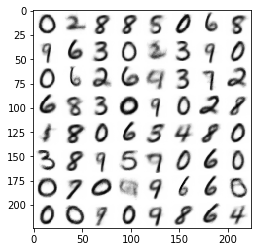

Train: Epoch: 711 | BCE: 0.16462 | KL Divergence: 3.64954
Val: Epoch: 711 | BCE: 0.18243 | KL Divergence: 3.66031
Train: Epoch: 712 | BCE: 0.16690 | KL Divergence: 3.67498
Val: Epoch: 712 | BCE: 0.18422 | KL Divergence: 3.65385
Train: Epoch: 713 | BCE: 0.16401 | KL Divergence: 3.67193
Val: Epoch: 713 | BCE: 0.18342 | KL Divergence: 3.67995
Train: Epoch: 714 | BCE: 0.16512 | KL Divergence: 3.65327
Val: Epoch: 714 | BCE: 0.18221 | KL Divergence: 3.65435
Train: Epoch: 715 | BCE: 0.16553 | KL Divergence: 3.65829
Val: Epoch: 715 | BCE: 0.18293 | KL Divergence: 3.67295
Train: Epoch: 716 | BCE: 0.16686 | KL Divergence: 3.66037
Val: Epoch: 716 | BCE: 0.18094 | KL Divergence: 3.68023
Train: Epoch: 717 | BCE: 0.16707 | KL Divergence: 3.65547
Val: Epoch: 717 | BCE: 0.18512 | KL Divergence: 3.64419
Train: Epoch: 718 | BCE: 0.16422 | KL Divergence: 3.66808
Val: Epoch: 718 | BCE: 0.17835 | KL Divergence: 3.66717
Train: Epoch: 719 | BCE: 0.16557 | KL Divergence: 3.66759
Val: Epoch: 719 | BCE: 0.18394

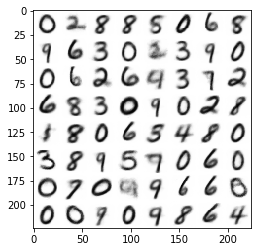

Train: Epoch: 721 | BCE: 0.16723 | KL Divergence: 3.65770
Val: Epoch: 721 | BCE: 0.18258 | KL Divergence: 3.67889
Train: Epoch: 722 | BCE: 0.16558 | KL Divergence: 3.66118
Val: Epoch: 722 | BCE: 0.18003 | KL Divergence: 3.66391
Train: Epoch: 723 | BCE: 0.16603 | KL Divergence: 3.66670
Val: Epoch: 723 | BCE: 0.18295 | KL Divergence: 3.66250
Train: Epoch: 724 | BCE: 0.16551 | KL Divergence: 3.66731
Val: Epoch: 724 | BCE: 0.18346 | KL Divergence: 3.63402
Train: Epoch: 725 | BCE: 0.16620 | KL Divergence: 3.67440
Val: Epoch: 725 | BCE: 0.18234 | KL Divergence: 3.64292
Train: Epoch: 726 | BCE: 0.16422 | KL Divergence: 3.67629
Val: Epoch: 726 | BCE: 0.18216 | KL Divergence: 3.66830
Train: Epoch: 727 | BCE: 0.16477 | KL Divergence: 3.66992
Val: Epoch: 727 | BCE: 0.18291 | KL Divergence: 3.68920
Train: Epoch: 728 | BCE: 0.16618 | KL Divergence: 3.66188
Val: Epoch: 728 | BCE: 0.18417 | KL Divergence: 3.65804
Train: Epoch: 729 | BCE: 0.16593 | KL Divergence: 3.64378
Val: Epoch: 729 | BCE: 0.18408

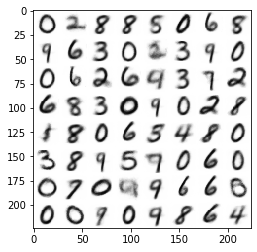

Train: Epoch: 731 | BCE: 0.16405 | KL Divergence: 3.67916
Val: Epoch: 731 | BCE: 0.18213 | KL Divergence: 3.67820
Train: Epoch: 732 | BCE: 0.16836 | KL Divergence: 3.66910
Val: Epoch: 732 | BCE: 0.18456 | KL Divergence: 3.68473
Train: Epoch: 733 | BCE: 0.16430 | KL Divergence: 3.67173
Val: Epoch: 733 | BCE: 0.18289 | KL Divergence: 3.67765
Train: Epoch: 734 | BCE: 0.16558 | KL Divergence: 3.67588
Val: Epoch: 734 | BCE: 0.18122 | KL Divergence: 3.69115
Train: Epoch: 735 | BCE: 0.16676 | KL Divergence: 3.65649
Val: Epoch: 735 | BCE: 0.18064 | KL Divergence: 3.68761
Train: Epoch: 736 | BCE: 0.16428 | KL Divergence: 3.67685
Val: Epoch: 736 | BCE: 0.18504 | KL Divergence: 3.67774
Train: Epoch: 737 | BCE: 0.16421 | KL Divergence: 3.67879
Val: Epoch: 737 | BCE: 0.18520 | KL Divergence: 3.72128
Train: Epoch: 738 | BCE: 0.16620 | KL Divergence: 3.66381
Val: Epoch: 738 | BCE: 0.18182 | KL Divergence: 3.66797
Train: Epoch: 739 | BCE: 0.16645 | KL Divergence: 3.65820
Val: Epoch: 739 | BCE: 0.18231

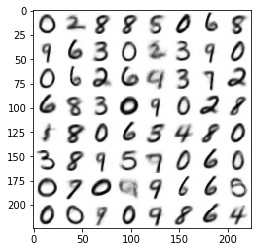

Train: Epoch: 741 | BCE: 0.16314 | KL Divergence: 3.66134
Val: Epoch: 741 | BCE: 0.18131 | KL Divergence: 3.65726
Train: Epoch: 742 | BCE: 0.16609 | KL Divergence: 3.66050
Val: Epoch: 742 | BCE: 0.18048 | KL Divergence: 3.67656
Train: Epoch: 743 | BCE: 0.16621 | KL Divergence: 3.68798
Val: Epoch: 743 | BCE: 0.18118 | KL Divergence: 3.69832
Train: Epoch: 744 | BCE: 0.16722 | KL Divergence: 3.69678
Val: Epoch: 744 | BCE: 0.18101 | KL Divergence: 3.67947
Train: Epoch: 745 | BCE: 0.16639 | KL Divergence: 3.68306
Val: Epoch: 745 | BCE: 0.18229 | KL Divergence: 3.66545
Train: Epoch: 746 | BCE: 0.16450 | KL Divergence: 3.68617
Val: Epoch: 746 | BCE: 0.18124 | KL Divergence: 3.71327
Train: Epoch: 747 | BCE: 0.16467 | KL Divergence: 3.68854
Val: Epoch: 747 | BCE: 0.18532 | KL Divergence: 3.66278
Train: Epoch: 748 | BCE: 0.16663 | KL Divergence: 3.68205
Val: Epoch: 748 | BCE: 0.18014 | KL Divergence: 3.67700
Train: Epoch: 749 | BCE: 0.16696 | KL Divergence: 3.68480
Val: Epoch: 749 | BCE: 0.18391

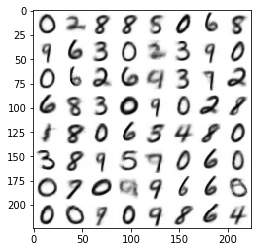

Train: Epoch: 751 | BCE: 0.16559 | KL Divergence: 3.67262
Val: Epoch: 751 | BCE: 0.18146 | KL Divergence: 3.66209
Train: Epoch: 752 | BCE: 0.16646 | KL Divergence: 3.67806
Val: Epoch: 752 | BCE: 0.18278 | KL Divergence: 3.68206
Train: Epoch: 753 | BCE: 0.16634 | KL Divergence: 3.68375
Val: Epoch: 753 | BCE: 0.18306 | KL Divergence: 3.66629
Train: Epoch: 754 | BCE: 0.16742 | KL Divergence: 3.67514
Val: Epoch: 754 | BCE: 0.18294 | KL Divergence: 3.65971
Train: Epoch: 755 | BCE: 0.16585 | KL Divergence: 3.68080
Val: Epoch: 755 | BCE: 0.18234 | KL Divergence: 3.69103
Train: Epoch: 756 | BCE: 0.16625 | KL Divergence: 3.68432
Val: Epoch: 756 | BCE: 0.18243 | KL Divergence: 3.71713
Train: Epoch: 757 | BCE: 0.16493 | KL Divergence: 3.69402
Val: Epoch: 757 | BCE: 0.18336 | KL Divergence: 3.69209
Train: Epoch: 758 | BCE: 0.16404 | KL Divergence: 3.69293
Val: Epoch: 758 | BCE: 0.18260 | KL Divergence: 3.69684
Train: Epoch: 759 | BCE: 0.16511 | KL Divergence: 3.70013
Val: Epoch: 759 | BCE: 0.18339

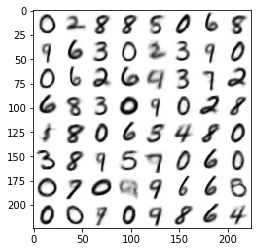

Train: Epoch: 761 | BCE: 0.16635 | KL Divergence: 3.68511
Val: Epoch: 761 | BCE: 0.18470 | KL Divergence: 3.67758
Train: Epoch: 762 | BCE: 0.16598 | KL Divergence: 3.68115
Val: Epoch: 762 | BCE: 0.18542 | KL Divergence: 3.68471
Train: Epoch: 763 | BCE: 0.16449 | KL Divergence: 3.69348
Val: Epoch: 763 | BCE: 0.18064 | KL Divergence: 3.66766
Train: Epoch: 764 | BCE: 0.16577 | KL Divergence: 3.68705
Val: Epoch: 764 | BCE: 0.18421 | KL Divergence: 3.68343
Train: Epoch: 765 | BCE: 0.16425 | KL Divergence: 3.70197
Val: Epoch: 765 | BCE: 0.18029 | KL Divergence: 3.70750
Train: Epoch: 766 | BCE: 0.16588 | KL Divergence: 3.68238
Val: Epoch: 766 | BCE: 0.18342 | KL Divergence: 3.67390
Train: Epoch: 767 | BCE: 0.16612 | KL Divergence: 3.67103
Val: Epoch: 767 | BCE: 0.18282 | KL Divergence: 3.67811
Train: Epoch: 768 | BCE: 0.16553 | KL Divergence: 3.68621
Val: Epoch: 768 | BCE: 0.17915 | KL Divergence: 3.68598
Train: Epoch: 769 | BCE: 0.16348 | KL Divergence: 3.68333
Val: Epoch: 769 | BCE: 0.18458

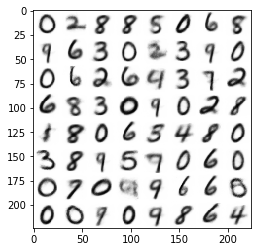

Train: Epoch: 771 | BCE: 0.16393 | KL Divergence: 3.69149
Val: Epoch: 771 | BCE: 0.18351 | KL Divergence: 3.70210
Train: Epoch: 772 | BCE: 0.16453 | KL Divergence: 3.67094
Val: Epoch: 772 | BCE: 0.18308 | KL Divergence: 3.69139
Train: Epoch: 773 | BCE: 0.16353 | KL Divergence: 3.69131
Val: Epoch: 773 | BCE: 0.18297 | KL Divergence: 3.71348
Train: Epoch: 774 | BCE: 0.16293 | KL Divergence: 3.69440
Val: Epoch: 774 | BCE: 0.18214 | KL Divergence: 3.70580
Train: Epoch: 775 | BCE: 0.16365 | KL Divergence: 3.68444
Val: Epoch: 775 | BCE: 0.18260 | KL Divergence: 3.67710
Train: Epoch: 776 | BCE: 0.16586 | KL Divergence: 3.69158
Val: Epoch: 776 | BCE: 0.18153 | KL Divergence: 3.68149
Train: Epoch: 777 | BCE: 0.16403 | KL Divergence: 3.68589
Val: Epoch: 777 | BCE: 0.18235 | KL Divergence: 3.71043
Train: Epoch: 778 | BCE: 0.16448 | KL Divergence: 3.70909
Val: Epoch: 778 | BCE: 0.18202 | KL Divergence: 3.68116
Train: Epoch: 779 | BCE: 0.16167 | KL Divergence: 3.71326
Val: Epoch: 779 | BCE: 0.18443

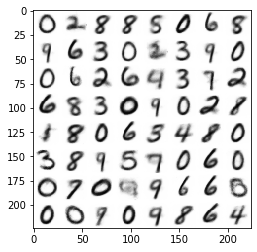

Train: Epoch: 781 | BCE: 0.16541 | KL Divergence: 3.69709
Val: Epoch: 781 | BCE: 0.18190 | KL Divergence: 3.70239
Train: Epoch: 782 | BCE: 0.16551 | KL Divergence: 3.68676
Val: Epoch: 782 | BCE: 0.18247 | KL Divergence: 3.69455
Train: Epoch: 783 | BCE: 0.16477 | KL Divergence: 3.68350
Val: Epoch: 783 | BCE: 0.18283 | KL Divergence: 3.74197
Train: Epoch: 784 | BCE: 0.16439 | KL Divergence: 3.69194
Val: Epoch: 784 | BCE: 0.18652 | KL Divergence: 3.69510
Train: Epoch: 785 | BCE: 0.16465 | KL Divergence: 3.69782
Val: Epoch: 785 | BCE: 0.18181 | KL Divergence: 3.69232
Train: Epoch: 786 | BCE: 0.16503 | KL Divergence: 3.69647
Val: Epoch: 786 | BCE: 0.18055 | KL Divergence: 3.70305
Train: Epoch: 787 | BCE: 0.16687 | KL Divergence: 3.68834
Val: Epoch: 787 | BCE: 0.18194 | KL Divergence: 3.72273
Train: Epoch: 788 | BCE: 0.16434 | KL Divergence: 3.69408
Val: Epoch: 788 | BCE: 0.18272 | KL Divergence: 3.66751
Train: Epoch: 789 | BCE: 0.16463 | KL Divergence: 3.69430
Val: Epoch: 789 | BCE: 0.18353

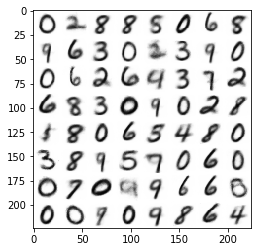

Train: Epoch: 791 | BCE: 0.16427 | KL Divergence: 3.71076
Val: Epoch: 791 | BCE: 0.18311 | KL Divergence: 3.73200
Train: Epoch: 792 | BCE: 0.16605 | KL Divergence: 3.69634
Val: Epoch: 792 | BCE: 0.18101 | KL Divergence: 3.71987
Train: Epoch: 793 | BCE: 0.16603 | KL Divergence: 3.70035
Val: Epoch: 793 | BCE: 0.18376 | KL Divergence: 3.70820
Train: Epoch: 794 | BCE: 0.16455 | KL Divergence: 3.68591
Val: Epoch: 794 | BCE: 0.18206 | KL Divergence: 3.70738
Train: Epoch: 795 | BCE: 0.16512 | KL Divergence: 3.71162
Val: Epoch: 795 | BCE: 0.18292 | KL Divergence: 3.70389
Train: Epoch: 796 | BCE: 0.16606 | KL Divergence: 3.70181
Val: Epoch: 796 | BCE: 0.18412 | KL Divergence: 3.70050
Train: Epoch: 797 | BCE: 0.16425 | KL Divergence: 3.69287
Val: Epoch: 797 | BCE: 0.18138 | KL Divergence: 3.70078
Train: Epoch: 798 | BCE: 0.16302 | KL Divergence: 3.70016
Val: Epoch: 798 | BCE: 0.18225 | KL Divergence: 3.70625
Train: Epoch: 799 | BCE: 0.16672 | KL Divergence: 3.68491
Val: Epoch: 799 | BCE: 0.18339

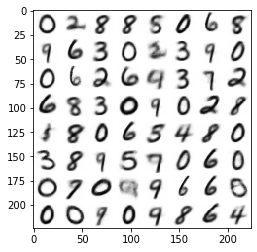

Train: Epoch: 801 | BCE: 0.16554 | KL Divergence: 3.70819
Val: Epoch: 801 | BCE: 0.17983 | KL Divergence: 3.71639
Train: Epoch: 802 | BCE: 0.16438 | KL Divergence: 3.70521
Val: Epoch: 802 | BCE: 0.18228 | KL Divergence: 3.68678
Train: Epoch: 803 | BCE: 0.16431 | KL Divergence: 3.68376
Val: Epoch: 803 | BCE: 0.17946 | KL Divergence: 3.70447
Train: Epoch: 804 | BCE: 0.16429 | KL Divergence: 3.70943
Val: Epoch: 804 | BCE: 0.18241 | KL Divergence: 3.69246
Train: Epoch: 805 | BCE: 0.16450 | KL Divergence: 3.69266
Val: Epoch: 805 | BCE: 0.18360 | KL Divergence: 3.71840
Train: Epoch: 806 | BCE: 0.16507 | KL Divergence: 3.71569
Val: Epoch: 806 | BCE: 0.18121 | KL Divergence: 3.74565
Train: Epoch: 807 | BCE: 0.16638 | KL Divergence: 3.71004
Val: Epoch: 807 | BCE: 0.18149 | KL Divergence: 3.73648
Train: Epoch: 808 | BCE: 0.16420 | KL Divergence: 3.69947
Val: Epoch: 808 | BCE: 0.18426 | KL Divergence: 3.70381
Train: Epoch: 809 | BCE: 0.16640 | KL Divergence: 3.69384
Val: Epoch: 809 | BCE: 0.18342

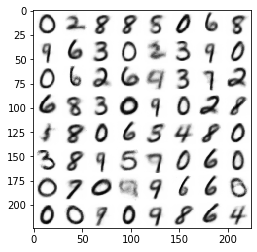

Train: Epoch: 811 | BCE: 0.16402 | KL Divergence: 3.71751
Val: Epoch: 811 | BCE: 0.18494 | KL Divergence: 3.72040
Train: Epoch: 812 | BCE: 0.16222 | KL Divergence: 3.71437
Val: Epoch: 812 | BCE: 0.18316 | KL Divergence: 3.69655
Train: Epoch: 813 | BCE: 0.16498 | KL Divergence: 3.71287
Val: Epoch: 813 | BCE: 0.18227 | KL Divergence: 3.73722
Train: Epoch: 814 | BCE: 0.16428 | KL Divergence: 3.69817
Val: Epoch: 814 | BCE: 0.18297 | KL Divergence: 3.68730
Train: Epoch: 815 | BCE: 0.16387 | KL Divergence: 3.72248
Val: Epoch: 815 | BCE: 0.18234 | KL Divergence: 3.69513
Train: Epoch: 816 | BCE: 0.16504 | KL Divergence: 3.72294
Val: Epoch: 816 | BCE: 0.18334 | KL Divergence: 3.72262
Train: Epoch: 817 | BCE: 0.16297 | KL Divergence: 3.71289
Val: Epoch: 817 | BCE: 0.18054 | KL Divergence: 3.70888
Train: Epoch: 818 | BCE: 0.16558 | KL Divergence: 3.70754
Val: Epoch: 818 | BCE: 0.18636 | KL Divergence: 3.72222
Train: Epoch: 819 | BCE: 0.16536 | KL Divergence: 3.72417
Val: Epoch: 819 | BCE: 0.18361

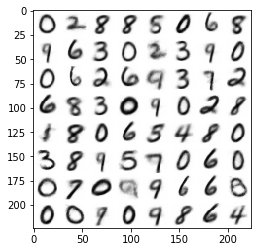

Train: Epoch: 821 | BCE: 0.16641 | KL Divergence: 3.72701
Val: Epoch: 821 | BCE: 0.18556 | KL Divergence: 3.70468
Train: Epoch: 822 | BCE: 0.16235 | KL Divergence: 3.73648
Val: Epoch: 822 | BCE: 0.18458 | KL Divergence: 3.73284
Train: Epoch: 823 | BCE: 0.16614 | KL Divergence: 3.70687
Val: Epoch: 823 | BCE: 0.18339 | KL Divergence: 3.69806
Train: Epoch: 824 | BCE: 0.16234 | KL Divergence: 3.70940
Val: Epoch: 824 | BCE: 0.18342 | KL Divergence: 3.71331
Train: Epoch: 825 | BCE: 0.16103 | KL Divergence: 3.70034
Val: Epoch: 825 | BCE: 0.18091 | KL Divergence: 3.73668
Train: Epoch: 826 | BCE: 0.16313 | KL Divergence: 3.71966
Val: Epoch: 826 | BCE: 0.18285 | KL Divergence: 3.74217
Train: Epoch: 827 | BCE: 0.16196 | KL Divergence: 3.71366
Val: Epoch: 827 | BCE: 0.18258 | KL Divergence: 3.73546
Train: Epoch: 828 | BCE: 0.16245 | KL Divergence: 3.71102
Val: Epoch: 828 | BCE: 0.17987 | KL Divergence: 3.70923
Train: Epoch: 829 | BCE: 0.16499 | KL Divergence: 3.70904
Val: Epoch: 829 | BCE: 0.18181

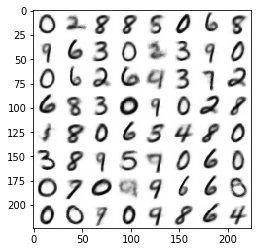

Train: Epoch: 831 | BCE: 0.16128 | KL Divergence: 3.75363
Val: Epoch: 831 | BCE: 0.18502 | KL Divergence: 3.72126
Train: Epoch: 832 | BCE: 0.16519 | KL Divergence: 3.72059
Val: Epoch: 832 | BCE: 0.18026 | KL Divergence: 3.74461
Train: Epoch: 833 | BCE: 0.16605 | KL Divergence: 3.70375
Val: Epoch: 833 | BCE: 0.18731 | KL Divergence: 3.71131
Train: Epoch: 834 | BCE: 0.16461 | KL Divergence: 3.71595
Val: Epoch: 834 | BCE: 0.18199 | KL Divergence: 3.68661
Train: Epoch: 835 | BCE: 0.16469 | KL Divergence: 3.72921
Val: Epoch: 835 | BCE: 0.18388 | KL Divergence: 3.73225
Train: Epoch: 836 | BCE: 0.16431 | KL Divergence: 3.71998
Val: Epoch: 836 | BCE: 0.18482 | KL Divergence: 3.73154
Train: Epoch: 837 | BCE: 0.16358 | KL Divergence: 3.71220
Val: Epoch: 837 | BCE: 0.18400 | KL Divergence: 3.71643
Train: Epoch: 838 | BCE: 0.16277 | KL Divergence: 3.73359
Val: Epoch: 838 | BCE: 0.17989 | KL Divergence: 3.75768
Train: Epoch: 839 | BCE: 0.16427 | KL Divergence: 3.73907
Val: Epoch: 839 | BCE: 0.18446

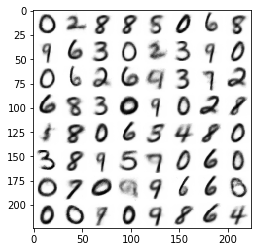

Train: Epoch: 841 | BCE: 0.16349 | KL Divergence: 3.71470
Val: Epoch: 841 | BCE: 0.18311 | KL Divergence: 3.70466
Train: Epoch: 842 | BCE: 0.16534 | KL Divergence: 3.71009
Val: Epoch: 842 | BCE: 0.18038 | KL Divergence: 3.74673
Train: Epoch: 843 | BCE: 0.16465 | KL Divergence: 3.72134
Val: Epoch: 843 | BCE: 0.18393 | KL Divergence: 3.71928
Train: Epoch: 844 | BCE: 0.16450 | KL Divergence: 3.72784
Val: Epoch: 844 | BCE: 0.18103 | KL Divergence: 3.70580
Train: Epoch: 845 | BCE: 0.16395 | KL Divergence: 3.74072
Val: Epoch: 845 | BCE: 0.18147 | KL Divergence: 3.73224
Train: Epoch: 846 | BCE: 0.16452 | KL Divergence: 3.72804
Val: Epoch: 846 | BCE: 0.18280 | KL Divergence: 3.75846
Train: Epoch: 847 | BCE: 0.16736 | KL Divergence: 3.72340
Val: Epoch: 847 | BCE: 0.18184 | KL Divergence: 3.72530
Train: Epoch: 848 | BCE: 0.16491 | KL Divergence: 3.73720
Val: Epoch: 848 | BCE: 0.18322 | KL Divergence: 3.71071
Train: Epoch: 849 | BCE: 0.16493 | KL Divergence: 3.72175
Val: Epoch: 849 | BCE: 0.18264

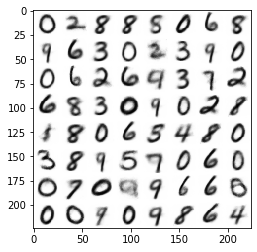

Train: Epoch: 851 | BCE: 0.16422 | KL Divergence: 3.70595
Val: Epoch: 851 | BCE: 0.18171 | KL Divergence: 3.72958
Train: Epoch: 852 | BCE: 0.16368 | KL Divergence: 3.73115
Val: Epoch: 852 | BCE: 0.18158 | KL Divergence: 3.72241
Train: Epoch: 853 | BCE: 0.16293 | KL Divergence: 3.74307
Val: Epoch: 853 | BCE: 0.18406 | KL Divergence: 3.73707
Train: Epoch: 854 | BCE: 0.16534 | KL Divergence: 3.73504
Val: Epoch: 854 | BCE: 0.18492 | KL Divergence: 3.72572
Train: Epoch: 855 | BCE: 0.16298 | KL Divergence: 3.74876
Val: Epoch: 855 | BCE: 0.18303 | KL Divergence: 3.73419
Train: Epoch: 856 | BCE: 0.16434 | KL Divergence: 3.71536
Val: Epoch: 856 | BCE: 0.18238 | KL Divergence: 3.69847
Train: Epoch: 857 | BCE: 0.16415 | KL Divergence: 3.73534
Val: Epoch: 857 | BCE: 0.18152 | KL Divergence: 3.74557
Train: Epoch: 858 | BCE: 0.16472 | KL Divergence: 3.72120
Val: Epoch: 858 | BCE: 0.18147 | KL Divergence: 3.73120
Train: Epoch: 859 | BCE: 0.16549 | KL Divergence: 3.71838
Val: Epoch: 859 | BCE: 0.18238

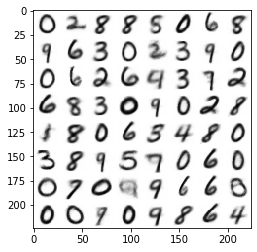

Train: Epoch: 861 | BCE: 0.16389 | KL Divergence: 3.74325
Val: Epoch: 861 | BCE: 0.18489 | KL Divergence: 3.73928
Train: Epoch: 862 | BCE: 0.16366 | KL Divergence: 3.73017
Val: Epoch: 862 | BCE: 0.18155 | KL Divergence: 3.76640
Train: Epoch: 863 | BCE: 0.16410 | KL Divergence: 3.73726
Val: Epoch: 863 | BCE: 0.18263 | KL Divergence: 3.72539
Train: Epoch: 864 | BCE: 0.16444 | KL Divergence: 3.73689
Val: Epoch: 864 | BCE: 0.18279 | KL Divergence: 3.73069
Train: Epoch: 865 | BCE: 0.16591 | KL Divergence: 3.73239
Val: Epoch: 865 | BCE: 0.18215 | KL Divergence: 3.76016
Train: Epoch: 866 | BCE: 0.16423 | KL Divergence: 3.72967
Val: Epoch: 866 | BCE: 0.18299 | KL Divergence: 3.72935
Train: Epoch: 867 | BCE: 0.16363 | KL Divergence: 3.73820
Val: Epoch: 867 | BCE: 0.18340 | KL Divergence: 3.73667
Train: Epoch: 868 | BCE: 0.16299 | KL Divergence: 3.71731
Val: Epoch: 868 | BCE: 0.18255 | KL Divergence: 3.71483
Train: Epoch: 869 | BCE: 0.16195 | KL Divergence: 3.73486
Val: Epoch: 869 | BCE: 0.18409

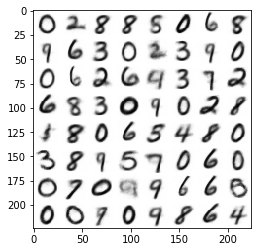

Train: Epoch: 871 | BCE: 0.16618 | KL Divergence: 3.71810
Val: Epoch: 871 | BCE: 0.18237 | KL Divergence: 3.73097
Train: Epoch: 872 | BCE: 0.16465 | KL Divergence: 3.71819
Val: Epoch: 872 | BCE: 0.18194 | KL Divergence: 3.74053
Train: Epoch: 873 | BCE: 0.16331 | KL Divergence: 3.73974
Val: Epoch: 873 | BCE: 0.18058 | KL Divergence: 3.74785
Train: Epoch: 874 | BCE: 0.16267 | KL Divergence: 3.73670
Val: Epoch: 874 | BCE: 0.18454 | KL Divergence: 3.75958
Train: Epoch: 875 | BCE: 0.16617 | KL Divergence: 3.72362
Val: Epoch: 875 | BCE: 0.18491 | KL Divergence: 3.71964
Train: Epoch: 876 | BCE: 0.16348 | KL Divergence: 3.74761
Val: Epoch: 876 | BCE: 0.18647 | KL Divergence: 3.75886
Train: Epoch: 877 | BCE: 0.16185 | KL Divergence: 3.75034
Val: Epoch: 877 | BCE: 0.18357 | KL Divergence: 3.72576
Train: Epoch: 878 | BCE: 0.16191 | KL Divergence: 3.73750
Val: Epoch: 878 | BCE: 0.18178 | KL Divergence: 3.73590
Train: Epoch: 879 | BCE: 0.16635 | KL Divergence: 3.73494
Val: Epoch: 879 | BCE: 0.18052

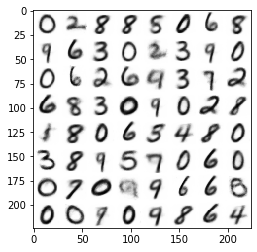

Train: Epoch: 881 | BCE: 0.16487 | KL Divergence: 3.73104
Val: Epoch: 881 | BCE: 0.18301 | KL Divergence: 3.75367
Train: Epoch: 882 | BCE: 0.16376 | KL Divergence: 3.75031
Val: Epoch: 882 | BCE: 0.18285 | KL Divergence: 3.76742
Train: Epoch: 883 | BCE: 0.16335 | KL Divergence: 3.73619
Val: Epoch: 883 | BCE: 0.18290 | KL Divergence: 3.73345
Train: Epoch: 884 | BCE: 0.16268 | KL Divergence: 3.73938
Val: Epoch: 884 | BCE: 0.18278 | KL Divergence: 3.72952
Train: Epoch: 885 | BCE: 0.16246 | KL Divergence: 3.75279
Val: Epoch: 885 | BCE: 0.18447 | KL Divergence: 3.74917
Train: Epoch: 886 | BCE: 0.16478 | KL Divergence: 3.74720
Val: Epoch: 886 | BCE: 0.18327 | KL Divergence: 3.75235
Train: Epoch: 887 | BCE: 0.16454 | KL Divergence: 3.73850
Val: Epoch: 887 | BCE: 0.18088 | KL Divergence: 3.77019
Train: Epoch: 888 | BCE: 0.16309 | KL Divergence: 3.75618
Val: Epoch: 888 | BCE: 0.18338 | KL Divergence: 3.73517
Train: Epoch: 889 | BCE: 0.16310 | KL Divergence: 3.74460
Val: Epoch: 889 | BCE: 0.18002

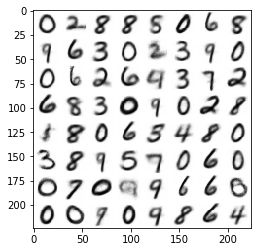

Train: Epoch: 891 | BCE: 0.16338 | KL Divergence: 3.75141
Val: Epoch: 891 | BCE: 0.18124 | KL Divergence: 3.77074
Train: Epoch: 892 | BCE: 0.16133 | KL Divergence: 3.76501
Val: Epoch: 892 | BCE: 0.17950 | KL Divergence: 3.72104
Train: Epoch: 893 | BCE: 0.16265 | KL Divergence: 3.74212
Val: Epoch: 893 | BCE: 0.18176 | KL Divergence: 3.75480
Train: Epoch: 894 | BCE: 0.16253 | KL Divergence: 3.74443
Val: Epoch: 894 | BCE: 0.18051 | KL Divergence: 3.78165
Train: Epoch: 895 | BCE: 0.16177 | KL Divergence: 3.74739
Val: Epoch: 895 | BCE: 0.18193 | KL Divergence: 3.73479
Train: Epoch: 896 | BCE: 0.16336 | KL Divergence: 3.75162
Val: Epoch: 896 | BCE: 0.18027 | KL Divergence: 3.75116
Train: Epoch: 897 | BCE: 0.16335 | KL Divergence: 3.73233
Val: Epoch: 897 | BCE: 0.18392 | KL Divergence: 3.74768
Train: Epoch: 898 | BCE: 0.16582 | KL Divergence: 3.74418
Val: Epoch: 898 | BCE: 0.18284 | KL Divergence: 3.75546
Train: Epoch: 899 | BCE: 0.16321 | KL Divergence: 3.73647
Val: Epoch: 899 | BCE: 0.18458

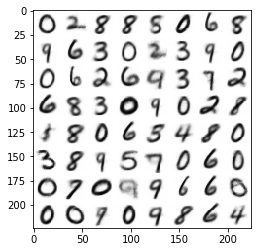

Train: Epoch: 901 | BCE: 0.16585 | KL Divergence: 3.74739
Val: Epoch: 901 | BCE: 0.18311 | KL Divergence: 3.74617
Train: Epoch: 902 | BCE: 0.16309 | KL Divergence: 3.75313
Val: Epoch: 902 | BCE: 0.18445 | KL Divergence: 3.74976
Train: Epoch: 903 | BCE: 0.16274 | KL Divergence: 3.74029
Val: Epoch: 903 | BCE: 0.18499 | KL Divergence: 3.76479
Train: Epoch: 904 | BCE: 0.16513 | KL Divergence: 3.76450
Val: Epoch: 904 | BCE: 0.18313 | KL Divergence: 3.72230
Train: Epoch: 905 | BCE: 0.16392 | KL Divergence: 3.73954
Val: Epoch: 905 | BCE: 0.18207 | KL Divergence: 3.73358
Train: Epoch: 906 | BCE: 0.16197 | KL Divergence: 3.75394
Val: Epoch: 906 | BCE: 0.18253 | KL Divergence: 3.76661
Train: Epoch: 907 | BCE: 0.16334 | KL Divergence: 3.75187
Val: Epoch: 907 | BCE: 0.18402 | KL Divergence: 3.78287
Train: Epoch: 908 | BCE: 0.16535 | KL Divergence: 3.75719
Val: Epoch: 908 | BCE: 0.18391 | KL Divergence: 3.76381
Train: Epoch: 909 | BCE: 0.16205 | KL Divergence: 3.75535
Val: Epoch: 909 | BCE: 0.18376

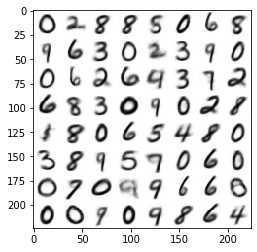

Train: Epoch: 911 | BCE: 0.16296 | KL Divergence: 3.74620
Val: Epoch: 911 | BCE: 0.18314 | KL Divergence: 3.73113
Train: Epoch: 912 | BCE: 0.15960 | KL Divergence: 3.75003
Val: Epoch: 912 | BCE: 0.18468 | KL Divergence: 3.77808
Train: Epoch: 913 | BCE: 0.16281 | KL Divergence: 3.75209
Val: Epoch: 913 | BCE: 0.18647 | KL Divergence: 3.72635
Train: Epoch: 914 | BCE: 0.16225 | KL Divergence: 3.76317
Val: Epoch: 914 | BCE: 0.18137 | KL Divergence: 3.76911
Train: Epoch: 915 | BCE: 0.16287 | KL Divergence: 3.75591
Val: Epoch: 915 | BCE: 0.18160 | KL Divergence: 3.77903
Train: Epoch: 916 | BCE: 0.16379 | KL Divergence: 3.74987
Val: Epoch: 916 | BCE: 0.18120 | KL Divergence: 3.77675
Train: Epoch: 917 | BCE: 0.16272 | KL Divergence: 3.76581
Val: Epoch: 917 | BCE: 0.18375 | KL Divergence: 3.74486
Train: Epoch: 918 | BCE: 0.16521 | KL Divergence: 3.76283
Val: Epoch: 918 | BCE: 0.18363 | KL Divergence: 3.75302
Train: Epoch: 919 | BCE: 0.16503 | KL Divergence: 3.74768
Val: Epoch: 919 | BCE: 0.18319

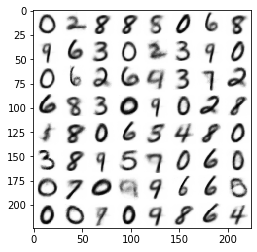

Train: Epoch: 921 | BCE: 0.16485 | KL Divergence: 3.74905
Val: Epoch: 921 | BCE: 0.18215 | KL Divergence: 3.75046
Train: Epoch: 922 | BCE: 0.16293 | KL Divergence: 3.76133
Val: Epoch: 922 | BCE: 0.18372 | KL Divergence: 3.76334
Train: Epoch: 923 | BCE: 0.16396 | KL Divergence: 3.77083
Val: Epoch: 923 | BCE: 0.18148 | KL Divergence: 3.76695
Train: Epoch: 924 | BCE: 0.16549 | KL Divergence: 3.75510
Val: Epoch: 924 | BCE: 0.18641 | KL Divergence: 3.76076
Train: Epoch: 925 | BCE: 0.16276 | KL Divergence: 3.76141
Val: Epoch: 925 | BCE: 0.18262 | KL Divergence: 3.74820
Train: Epoch: 926 | BCE: 0.16310 | KL Divergence: 3.76088
Val: Epoch: 926 | BCE: 0.18274 | KL Divergence: 3.77446
Train: Epoch: 927 | BCE: 0.16264 | KL Divergence: 3.75558
Val: Epoch: 927 | BCE: 0.18417 | KL Divergence: 3.73741
Train: Epoch: 928 | BCE: 0.16307 | KL Divergence: 3.75330
Val: Epoch: 928 | BCE: 0.18225 | KL Divergence: 3.76480
Train: Epoch: 929 | BCE: 0.16311 | KL Divergence: 3.75136
Val: Epoch: 929 | BCE: 0.18365

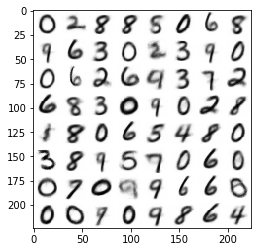

Train: Epoch: 931 | BCE: 0.16185 | KL Divergence: 3.75602
Val: Epoch: 931 | BCE: 0.18400 | KL Divergence: 3.73549
Train: Epoch: 932 | BCE: 0.16407 | KL Divergence: 3.75767
Val: Epoch: 932 | BCE: 0.18233 | KL Divergence: 3.79987
Train: Epoch: 933 | BCE: 0.16296 | KL Divergence: 3.75171
Val: Epoch: 933 | BCE: 0.18252 | KL Divergence: 3.74871
Train: Epoch: 934 | BCE: 0.16136 | KL Divergence: 3.76304
Val: Epoch: 934 | BCE: 0.18308 | KL Divergence: 3.76223
Train: Epoch: 935 | BCE: 0.16410 | KL Divergence: 3.74648
Val: Epoch: 935 | BCE: 0.18457 | KL Divergence: 3.75665
Train: Epoch: 936 | BCE: 0.16123 | KL Divergence: 3.76110
Val: Epoch: 936 | BCE: 0.18382 | KL Divergence: 3.75653
Train: Epoch: 937 | BCE: 0.16300 | KL Divergence: 3.75640
Val: Epoch: 937 | BCE: 0.18330 | KL Divergence: 3.75694
Train: Epoch: 938 | BCE: 0.16243 | KL Divergence: 3.75451
Val: Epoch: 938 | BCE: 0.18292 | KL Divergence: 3.76076
Train: Epoch: 939 | BCE: 0.16327 | KL Divergence: 3.75371
Val: Epoch: 939 | BCE: 0.18337

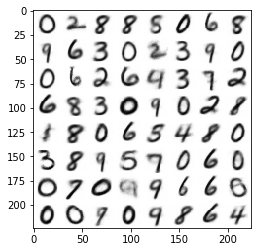

Train: Epoch: 941 | BCE: 0.16192 | KL Divergence: 3.77166
Val: Epoch: 941 | BCE: 0.18208 | KL Divergence: 3.77725
Train: Epoch: 942 | BCE: 0.16139 | KL Divergence: 3.76566
Val: Epoch: 942 | BCE: 0.18530 | KL Divergence: 3.73790
Train: Epoch: 943 | BCE: 0.16201 | KL Divergence: 3.76144
Val: Epoch: 943 | BCE: 0.18175 | KL Divergence: 3.78427
Train: Epoch: 944 | BCE: 0.16447 | KL Divergence: 3.77265
Val: Epoch: 944 | BCE: 0.17848 | KL Divergence: 3.78840
Train: Epoch: 945 | BCE: 0.16314 | KL Divergence: 3.77840
Val: Epoch: 945 | BCE: 0.18333 | KL Divergence: 3.77116
Train: Epoch: 946 | BCE: 0.16224 | KL Divergence: 3.76963
Val: Epoch: 946 | BCE: 0.18128 | KL Divergence: 3.76140
Train: Epoch: 947 | BCE: 0.16206 | KL Divergence: 3.76768
Val: Epoch: 947 | BCE: 0.18151 | KL Divergence: 3.76987
Train: Epoch: 948 | BCE: 0.16232 | KL Divergence: 3.75838
Val: Epoch: 948 | BCE: 0.18270 | KL Divergence: 3.79438
Train: Epoch: 949 | BCE: 0.16172 | KL Divergence: 3.76885
Val: Epoch: 949 | BCE: 0.18161

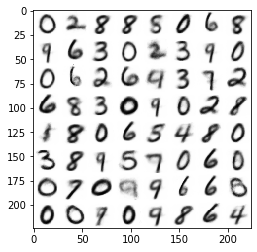

Train: Epoch: 951 | BCE: 0.16365 | KL Divergence: 3.76214
Val: Epoch: 951 | BCE: 0.18195 | KL Divergence: 3.79204
Train: Epoch: 952 | BCE: 0.16277 | KL Divergence: 3.77167
Val: Epoch: 952 | BCE: 0.18413 | KL Divergence: 3.79510
Train: Epoch: 953 | BCE: 0.16611 | KL Divergence: 3.77709
Val: Epoch: 953 | BCE: 0.18299 | KL Divergence: 3.74564
Train: Epoch: 954 | BCE: 0.16483 | KL Divergence: 3.75974
Val: Epoch: 954 | BCE: 0.18326 | KL Divergence: 3.75939
Train: Epoch: 955 | BCE: 0.16485 | KL Divergence: 3.76307
Val: Epoch: 955 | BCE: 0.18605 | KL Divergence: 3.72561
Train: Epoch: 956 | BCE: 0.16353 | KL Divergence: 3.77221
Val: Epoch: 956 | BCE: 0.18388 | KL Divergence: 3.76792
Train: Epoch: 957 | BCE: 0.16368 | KL Divergence: 3.77452
Val: Epoch: 957 | BCE: 0.18429 | KL Divergence: 3.76082
Train: Epoch: 958 | BCE: 0.16215 | KL Divergence: 3.77606
Val: Epoch: 958 | BCE: 0.18253 | KL Divergence: 3.79510
Train: Epoch: 959 | BCE: 0.16059 | KL Divergence: 3.79041
Val: Epoch: 959 | BCE: 0.18118

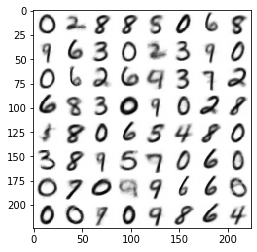

Train: Epoch: 961 | BCE: 0.16249 | KL Divergence: 3.76633
Val: Epoch: 961 | BCE: 0.18533 | KL Divergence: 3.78763
Train: Epoch: 962 | BCE: 0.16236 | KL Divergence: 3.77178
Val: Epoch: 962 | BCE: 0.18034 | KL Divergence: 3.79122
Train: Epoch: 963 | BCE: 0.16137 | KL Divergence: 3.78997
Val: Epoch: 963 | BCE: 0.18545 | KL Divergence: 3.78261
Train: Epoch: 964 | BCE: 0.16118 | KL Divergence: 3.78094
Val: Epoch: 964 | BCE: 0.18304 | KL Divergence: 3.76962
Train: Epoch: 965 | BCE: 0.16171 | KL Divergence: 3.75483
Val: Epoch: 965 | BCE: 0.18554 | KL Divergence: 3.76264
Train: Epoch: 966 | BCE: 0.16472 | KL Divergence: 3.75435
Val: Epoch: 966 | BCE: 0.18536 | KL Divergence: 3.76415
Train: Epoch: 967 | BCE: 0.16138 | KL Divergence: 3.77778
Val: Epoch: 967 | BCE: 0.18142 | KL Divergence: 3.76842
Train: Epoch: 968 | BCE: 0.16138 | KL Divergence: 3.78399
Val: Epoch: 968 | BCE: 0.18580 | KL Divergence: 3.77775
Train: Epoch: 969 | BCE: 0.16215 | KL Divergence: 3.78043
Val: Epoch: 969 | BCE: 0.18359

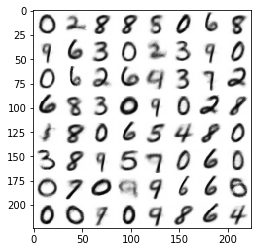

Train: Epoch: 971 | BCE: 0.16241 | KL Divergence: 3.76993
Val: Epoch: 971 | BCE: 0.18306 | KL Divergence: 3.77421
Train: Epoch: 972 | BCE: 0.16297 | KL Divergence: 3.75740
Val: Epoch: 972 | BCE: 0.18515 | KL Divergence: 3.78025
Train: Epoch: 973 | BCE: 0.16330 | KL Divergence: 3.77970
Val: Epoch: 973 | BCE: 0.18501 | KL Divergence: 3.77446
Train: Epoch: 974 | BCE: 0.16234 | KL Divergence: 3.77550
Val: Epoch: 974 | BCE: 0.18658 | KL Divergence: 3.77790
Train: Epoch: 975 | BCE: 0.16221 | KL Divergence: 3.78824
Val: Epoch: 975 | BCE: 0.18635 | KL Divergence: 3.80099
Train: Epoch: 976 | BCE: 0.16162 | KL Divergence: 3.79238
Val: Epoch: 976 | BCE: 0.18307 | KL Divergence: 3.78600
Train: Epoch: 977 | BCE: 0.16111 | KL Divergence: 3.78231
Val: Epoch: 977 | BCE: 0.18173 | KL Divergence: 3.80548
Train: Epoch: 978 | BCE: 0.16149 | KL Divergence: 3.80339
Val: Epoch: 978 | BCE: 0.18023 | KL Divergence: 3.77269
Train: Epoch: 979 | BCE: 0.16309 | KL Divergence: 3.77562
Val: Epoch: 979 | BCE: 0.18328

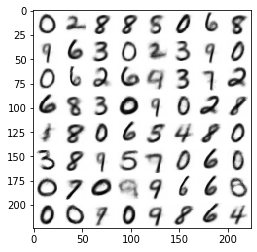

Train: Epoch: 981 | BCE: 0.16053 | KL Divergence: 3.78232
Val: Epoch: 981 | BCE: 0.18146 | KL Divergence: 3.78617
Train: Epoch: 982 | BCE: 0.16060 | KL Divergence: 3.78984
Val: Epoch: 982 | BCE: 0.18435 | KL Divergence: 3.80415
Train: Epoch: 983 | BCE: 0.16240 | KL Divergence: 3.76863
Val: Epoch: 983 | BCE: 0.18588 | KL Divergence: 3.76509
Train: Epoch: 984 | BCE: 0.16381 | KL Divergence: 3.77864
Val: Epoch: 984 | BCE: 0.18581 | KL Divergence: 3.73946
Train: Epoch: 985 | BCE: 0.16298 | KL Divergence: 3.76982
Val: Epoch: 985 | BCE: 0.18426 | KL Divergence: 3.77308
Train: Epoch: 986 | BCE: 0.16079 | KL Divergence: 3.78146
Val: Epoch: 986 | BCE: 0.18537 | KL Divergence: 3.77119
Train: Epoch: 987 | BCE: 0.16286 | KL Divergence: 3.78381
Val: Epoch: 987 | BCE: 0.18255 | KL Divergence: 3.80953
Train: Epoch: 988 | BCE: 0.16230 | KL Divergence: 3.78267
Val: Epoch: 988 | BCE: 0.18376 | KL Divergence: 3.79803
Train: Epoch: 989 | BCE: 0.16083 | KL Divergence: 3.79004
Val: Epoch: 989 | BCE: 0.18326

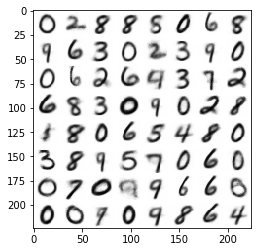

Train: Epoch: 991 | BCE: 0.16197 | KL Divergence: 3.78520
Val: Epoch: 991 | BCE: 0.18293 | KL Divergence: 3.76419
Train: Epoch: 992 | BCE: 0.16166 | KL Divergence: 3.79048
Val: Epoch: 992 | BCE: 0.18327 | KL Divergence: 3.81257
Train: Epoch: 993 | BCE: 0.16111 | KL Divergence: 3.77474
Val: Epoch: 993 | BCE: 0.18314 | KL Divergence: 3.83427
Train: Epoch: 994 | BCE: 0.16222 | KL Divergence: 3.79488
Val: Epoch: 994 | BCE: 0.18418 | KL Divergence: 3.77066
Train: Epoch: 995 | BCE: 0.15948 | KL Divergence: 3.78743
Val: Epoch: 995 | BCE: 0.18411 | KL Divergence: 3.77942
Train: Epoch: 996 | BCE: 0.16150 | KL Divergence: 3.79617
Val: Epoch: 996 | BCE: 0.18368 | KL Divergence: 3.78469
Train: Epoch: 997 | BCE: 0.16119 | KL Divergence: 3.79539
Val: Epoch: 997 | BCE: 0.18307 | KL Divergence: 3.80560
Train: Epoch: 998 | BCE: 0.16144 | KL Divergence: 3.78879
Val: Epoch: 998 | BCE: 0.18479 | KL Divergence: 3.77981
Train: Epoch: 999 | BCE: 0.16256 | KL Divergence: 3.78073
Val: Epoch: 999 | BCE: 0.18360

In [ ]:
for epoch in range(EPOCHS):

    train_indices = np.random.permutation(X_train.shape[0])
    _X_train = X_train[train_indices]
    _y_train = y_train[train_indices]

    test_indices = np.random.permutation(X_test.shape[0])
    _X_test = X_test[test_indices]
    _y_test = y_test[test_indices]
    
    train_reconstruction_loss, train_kl_divergence = train_epoch(_X_train, _y_train, criterion, optimizer_e, optimizer_d, batch_size=batch_size)
    print('Train: Epoch: {} | BCE: {:.5f} | KL Divergence: {:.5f}'.format(epoch, train_reconstruction_loss, train_kl_divergence))
    val_reconstruction_loss, val_kl_divergence = val_epoch(_X_test, _y_test, criterion, batch_size)
    print('Val: Epoch: {} | BCE: {:.5f} | KL Divergence: {:.5f}'.format(epoch, val_reconstruction_loss, val_kl_divergence))
    
    if epoch % 10 == 0:
        visualize(fixed_noise_vector)

In [ ]:
dec = decoder.eval().to(device)
enc = encoder.eval().to(device)

In [ ]:
def interpolate(X, y, from_digit=1, to_digit=0, steps=30, enc=None, dec=None):
    """
    Interpolate from one digit to another
    """
    idx = int(np.random.randint(0, 100))
    X_from = X[y == from_digit][52]
    X_to = X[y == to_digit][52]
    
    X_from = torch.FloatTensor(np.expand_dims(X_from, axis=0)).to(device)
    X_to = torch.FloatTensor(np.expand_dims(X_to, axis=0)).to(device)
    
    mu_from, log_var_from = enc(X_from)
    mu_to, log_var_to = enc(X_to)
    
    z_from = mu_from + torch.randn_like(mu_from) * torch.exp(log_var_from / 2.)
    z_to = mu_to + torch.randn_like(mu_to) * torch.exp(log_var_to / 2.)
    
    grid = np.zeros((28, 28*steps), dtype=np.uint8)
    
    images = []
    for eps in np.linspace(0., 1., steps):
        z = z_from + (z_to - z_from) * eps
        image = dec(z.unsqueeze(0))
        images.append(image.detach().cpu().numpy())
        
    for i, img in enumerate(images):
        _img = img[0] * 255.
        _img = _img.astype(np.uint8)
        
        grid[:, i*28:i*28+28] = _img
        
    f = plt.figure(figsize=(20, 20))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.show()

    return images

In [ ]:
def interpolate_multiple(X, y, from_digit=1, to_digit1=0, to_digit2=7, steps=10, enc=None, dec=None):
    """
    Interpolate from one digit to another, then to another
    """
    X_from = X[y == from_digit][8] # Any random index
    X_to1 = X[y == to_digit1][89]
    X_to2 = X[y == to_digit2][56]
    
    X_from = torch.FloatTensor(np.expand_dims(X_from, axis=0)).to(device)
    X_to1 = torch.FloatTensor(np.expand_dims(X_to1, axis=0)).to(device)
    X_to2 = torch.FloatTensor(np.expand_dims(X_to2, axis=0)).to(device)
    
    mu_from, log_var_from = enc(X_from)
    mu_to1, log_var_to1 = enc(X_to1)
    mu_to2, log_var_to2 = enc(X_to2)
    
    z_from = mu_from + torch.randn_like(mu_from) * torch.exp(log_var_from / 2.)
    z_to1 = mu_to1 + torch.randn_like(mu_to1) * torch.exp(log_var_to1 / 2.)
    z_to2 = mu_to2 + torch.randn_like(mu_to2) * torch.exp(log_var_to2 / 2.)
    
    grid = np.zeros((28, 28*steps*2 - 28), dtype=np.uint8)
    
    images = []
    for eps in np.linspace(0., 1., steps):
        z1 = z_from + (z_to1 - z_from) * eps
        
        image = dec(z1.unsqueeze(0))
        images.append(image.detach().cpu().numpy())
        
    for idx, eps in enumerate(np.linspace(0., 1., steps)):
        if idx == 0:
            continue
        z2 = (z_to1 + (z_to2 - z_to1) * eps)
        image = dec(z2.unsqueeze(0))
        images.append(image.detach().cpu().numpy())

    for i, img in enumerate(images):
        _img = img[0] * 255.
        _img = _img.astype(np.uint8)
        
        grid[:, i*28:i*28+28] = _img
        
    f = plt.figure(figsize=(20, 20))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.show()

    return images

In [ ]:
def interpolate_multiple2(X, y, from_digit=1, to_digit1=0, to_digit2=7, steps=10, enc=None, dec=None):
    """
    Interpolate from one digit to another, then to another, and back to the starting digit
    """

    X_from = X[y == from_digit][80] # Any random index
    X_to1 = X[y == to_digit1][72]
    X_to2 = X[y == to_digit2][67]
    
    X_from = torch.FloatTensor(np.expand_dims(X_from, axis=0)).to(device)
    X_to1 = torch.FloatTensor(np.expand_dims(X_to1, axis=0)).to(device)
    X_to2 = torch.FloatTensor(np.expand_dims(X_to2, axis=0)).to(device)
    
    mu_from, log_var_from = enc(X_from)
    mu_to1, log_var_to1 = enc(X_to1)
    mu_to2, log_var_to2 = enc(X_to2)
    
    z_from = mu_from + torch.randn_like(mu_from) * torch.exp(log_var_from / 2.)
    z_to1 = mu_to1 + torch.randn_like(mu_to1) * torch.exp(log_var_to1 / 2.)
    z_to2 = mu_to2 + torch.randn_like(mu_to2) * torch.exp(log_var_to2 / 2.)
    
    grid = np.zeros((28, 28*steps*3 - 2*28), dtype=np.uint8)
    
    images = []
    for eps in np.linspace(0., 1., steps):
        z1 = z_from + (z_to1 - z_from) * eps
        
        image = dec(z1.unsqueeze(0))
        images.append(image.detach().cpu().numpy())
        
    for idx, eps in enumerate(np.linspace(0., 1., steps)):
        if idx == 0:
            continue
        z2 = (z_to1 + (z_to2 - z_to1) * eps)
        image = dec(z2.unsqueeze(0))
        images.append(image.detach().cpu().numpy())

    for idx, eps in enumerate(np.linspace(0., 1., steps)):
        if idx == 0:
            continue
        z4 = (z_to2 + (z_from - z_to2) * eps)
        image = dec(z4.unsqueeze(0))
        images.append(image.detach().cpu().numpy())

    for i, img in enumerate(images):
        _img = img[0] * 255.
        _img = _img.astype(np.uint8)
        
        grid[:, i*28:i*28+28] = _img
        
    f = plt.figure(figsize=(20, 20))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.show()

    return images

In [ ]:
for i in [9]:
    imgs = interpolate(X_test, y_test, from_digit=1, to_digit=i, steps=150, enc=enc, dec=dec)
    # Uncomment to save as a gif
    # imageio.mimwrite(base_path + 'b_interpolation_{}to{}.gif'.format(1, i), [(ing[0, 0, :, :] * 255.).astype(np.uint8) for ing in imgs], fps=15)
    # imageio.mimwrite(base_path + 'w_interpolation_{}to{}.gif'.format(1, i), [((1. - ing[0, 0, :, :]) * 255.).astype(np.uint8) for ing in imgs], fps=15)

91


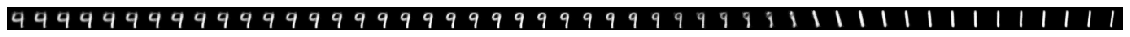

In [ ]:
imgs = interpolate_multiple(X_test, y_test, from_digit=4, to_digit1=9, 
                            to_digit2=1, steps=25, 
                            enc=enc, dec=dec)
# Uncomment to save as gif
# imageio.mimwrite(base_path + 'vae_interpolation_loop.gif', [(imgs[0, 0, :, :] * 255.).astype(np.uint8) for img in imgs], fps=15)

In [ ]:
imgs2 = interpolate_multiple2(X_test, y_test, from_digit=1, to_digit1=0, 
                            to_digit2=9, steps=75, 
                            enc=enc, dec=dec)
# Uncomment to save as gif
# imageio.mimwrite(base_path + 'vae_interpolation_loop_v5.gif', [(ing[0, 0, :, :] * 255.).astype(np.uint8) for ing in imgs2], fps=10)

# Jitter Experiments:
See what happens when we perturb one of the latent dimensions 

In [ ]:
def perturb(X, y, steps=10, dec=None, save=False):
    """
    We can generate the entire grid as a batch. This is not feasible for large
    number of steps
    """
    # Generate samples from the support of p(z)
    x = norm.ppf(np.linspace(0.05, 0.95, num=steps))
    y = norm.ppf(np.linspace(0.05, 0.95, num=steps))
    l_x = x.shape[0]
    l_y = y.shape[0]
    x_grid = np.repeat(x, l_y).reshape(-1, 1)
    y_grid = np.tile(y, l_x).reshape(-1, 1)
    _z = np.concatenate([x_grid, y_grid], axis=1)

    z = torch.from_numpy(_z).float().to(device)
    
    grid = np.zeros((28*x.shape[0], 28*y.shape[0]), dtype=np.uint8)
    
    images = dec(z).detach().cpu().numpy()
    
    ptr = 0
    for i, _x in enumerate(x):
        for j, _y in enumerate(y):
        
            img = images[ptr, 0, ...]
            _img = img * 255.
            _img = _img.astype(np.uint8)
            
            grid[i*28:i*28+28, j*28:j*28+28] = _img

            ptr += 1
        
    f = plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.show()

    if save:
        grid_img = Image.fromarray(grid)
        grid_img.save(base_path + 'vae_mnist_manifold.png')
        grid_img.close()

In [ ]:
def perturb_iterative(X, y, steps=10, dec=None, save=False):
    """
    For a large number of steps, generate the grid iteratively
    """
    # Generate samples from the support of p(z)
    x = norm.ppf(np.linspace(0.05, 0.95, num=steps))
    y = norm.ppf(np.linspace(0.05, 0.95, num=steps))
    l_x = x.shape[0]
    l_y = y.shape[0]
    x_grid = np.repeat(x, l_y).reshape(-1, 1)
    y_grid = np.tile(y, l_x).reshape(-1, 1)
    _z = np.concatenate([x_grid, y_grid], axis=1)
    
    grid = np.zeros((28*x.shape[0], 28*y.shape[0]), dtype=np.uint8)
    n_rows, n_cols = grid.shape

    images_l = []
    for k in range(_z.shape[0]):
        z = torch.from_numpy(_z[k]).unsqueeze(dim=0).float().to(device)
        images_l.append(dec(z).detach().cpu().numpy())
    
    ptr = 0
    for i, _x in enumerate(x): # -1, -1, ..0, 0, 
        for j, _x in enumerate(x): # -1, 0, 1,
        
            img = images_l[ptr][0, ...]
            _img = img * 255.
            _img = _img.astype(np.uint8)
            
            grid[n_rows-(j*28+28):n_rows-j*28, i*28:i*28+28] = _img

            ptr += 1
        
    f = plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.show()

    if save:
        grid_img = Image.fromarray(grid)
        grid_img.save(base_path + 'vae_mnist_manifold_{}_v3.png'.format(steps))
        grid_img.close()

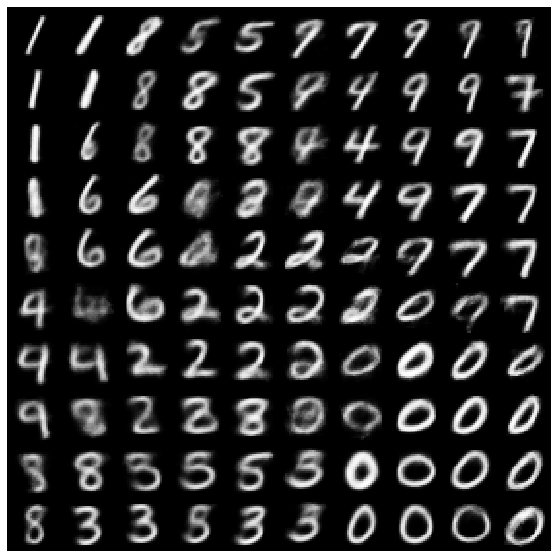

In [ ]:
perturb_iterative(X_test, y_test, steps=10, dec=decoder, save=False)

In [ ]:
def plot_latent(X, y, enc, samples_per_class=10):

    """
    Plot the transformed samples from the test set
    """

    fig = plt.figure(figsize=(10, 10))

    for digit in range(10):

        # Draw 10 random samples
        _X = X[y == digit]
        _y = y[y == digit]
        indices = np.random.permutation(np.arange(_X.shape[0]))
        _X = _X[indices[:samples_per_class]]

        X_sample = torch.from_numpy(_X).float().to(device)

        mu, log_var = enc(X_sample)
        z = (mu + torch.randn_like(mu) * torch.exp(log_var / 2.)).detach().cpu().numpy()

        plt.scatter(z[:, 0], z[:, 1], c=None, alpha=0.7)
    plt.legend([_ for _ in range(10)])
    plt.xlabel('z1')
    plt.ylabel('z2')
    # plt.savefig(base_path + '/vae_latent_plot_v3.png', dpi=300)
    plt.show()


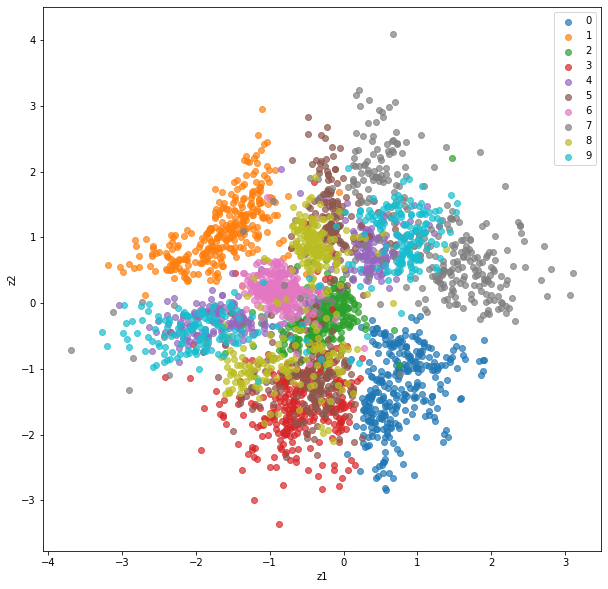

In [ ]:
# Plot the transformed samples from the test set
plot_latent(X_test, y_test, encoder, samples_per_class=300)